# Imports

In [41]:
import numpy as np 
import pandas as pd 
import os

import matplotlib.pyplot as plt
import csv
import itertools
import collections

import pywt
from scipy import stats

from sklearn.utils import resample
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Conv1D, AvgPool1D, Flatten, Dense, Dropout, Softmax,LSTM,GRU
from tensorflow.keras.optimizers import Adam 
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras import regularizers


%matplotlib inline

In [42]:
plt.rcParams["figure.figsize"] = (30,6)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True 

# Reading the Input Data

In [43]:
path = 'D:/1buatTA/mitbih_database/mitbih_database/'  
#input path
window_size = 180
maximum_counting = 10000

classes = ['N', 'L', 'R', 'A', 'V']
n_classes = len(classes)
count_classes = [0]*n_classes

X = list()
y = list()

##Reading files

In [44]:
# Readint input files
filenames = next(os.walk(path))[2]

# Splitting the csv files and annotation files
records = list()
annotations = list()
filenames.sort()

#Seperating files and annotations

In [45]:
# grouping csv and annotation files
for f in filenames:
    filename, file_extension = os.path.splitext(f)
    
    # *.csv
    if(file_extension == '.csv'):
        records.append(path + filename + file_extension)

    # *.txt
    else:
        annotations.append(path + filename + file_extension)

In [46]:
print(len(records))

48


# Data Denoising

In [47]:
def denoise(data): 
    w = pywt.Wavelet('sym4') #syn4 - 4 max level decomposition
    maxlev = pywt.dwt_max_level(len(data), w.dec_len) #max useful decomposition
    threshold = 0.04 # filtering threshold

    coeffs = pywt.wavedec(data, 'sym4', level=maxlev) #adding coefficients
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
        
    datarec = pywt.waverec(coeffs, 'sym4') #waverec
    
    return datarec

#Reading R positions and Arrhythmia class

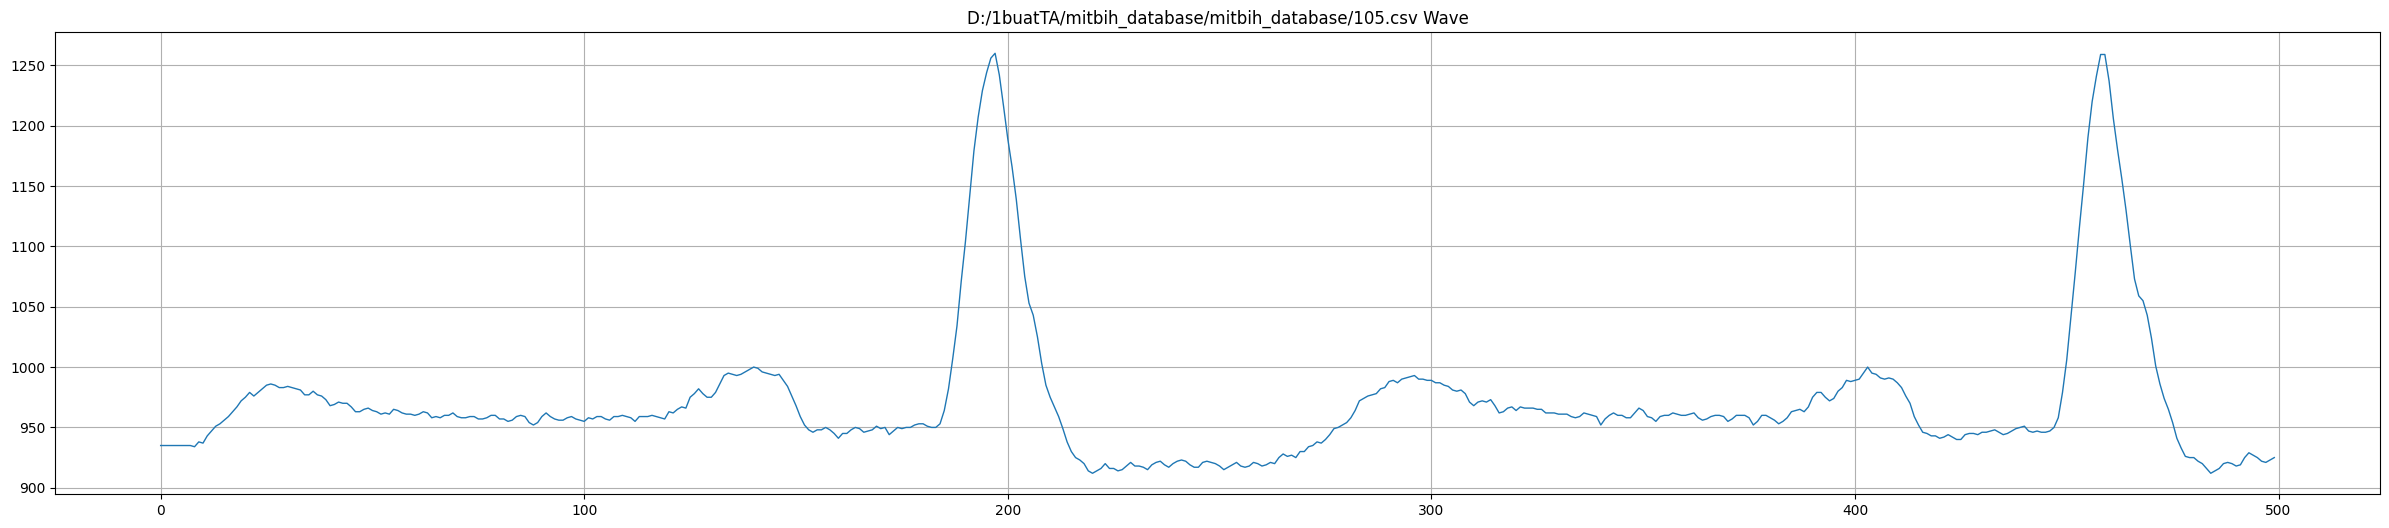

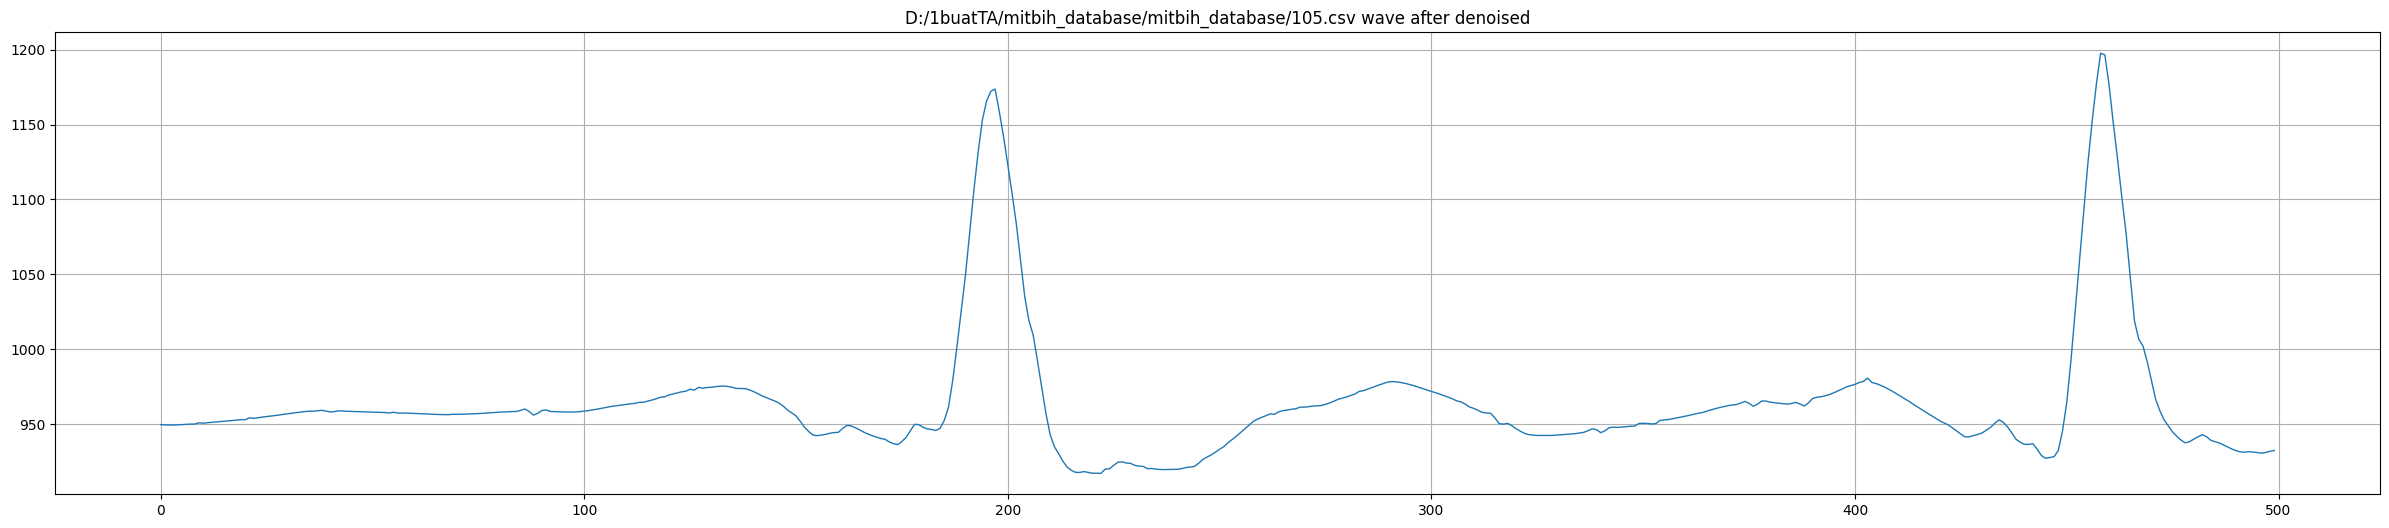

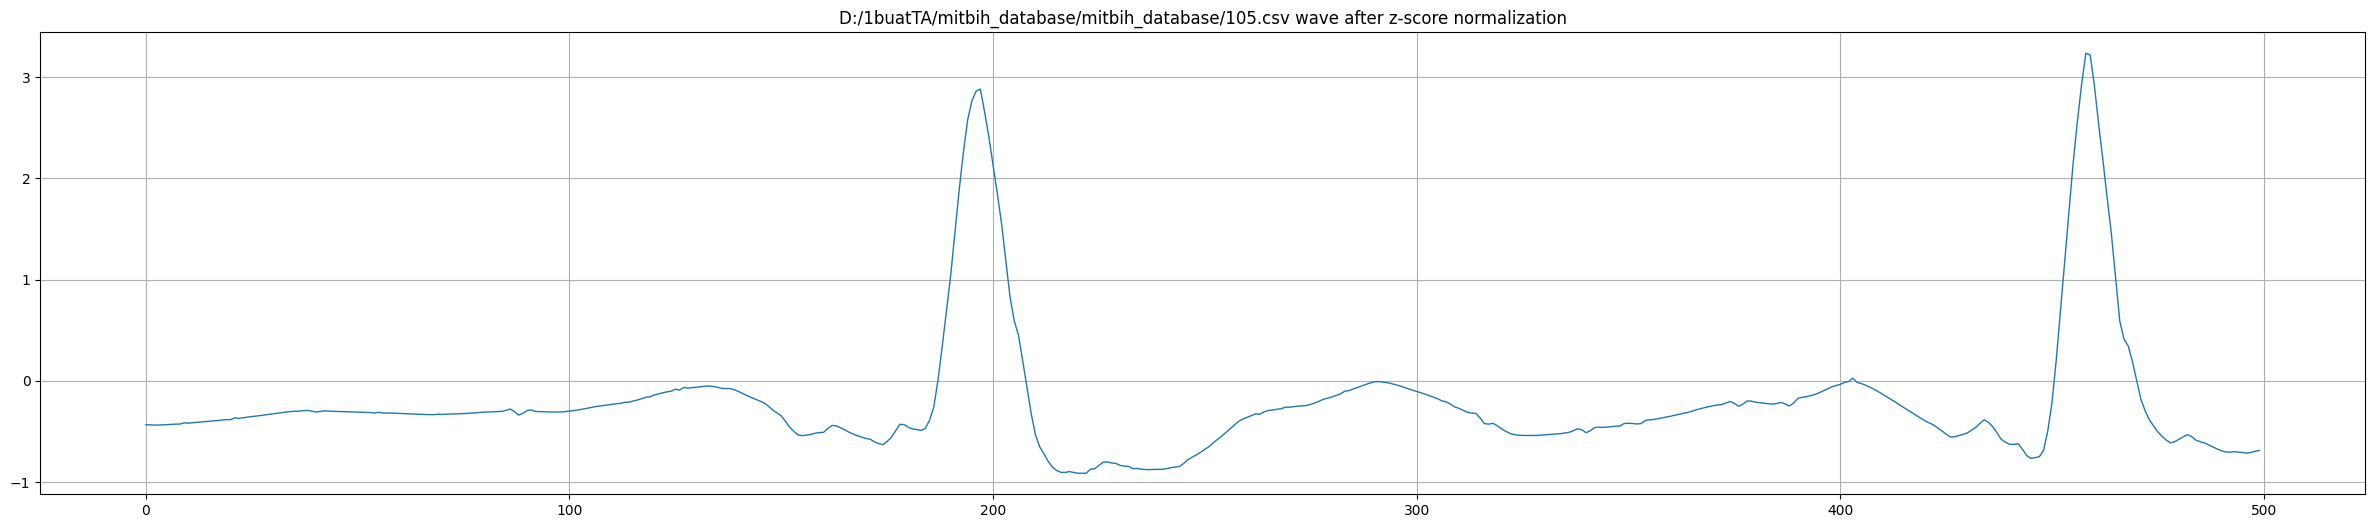

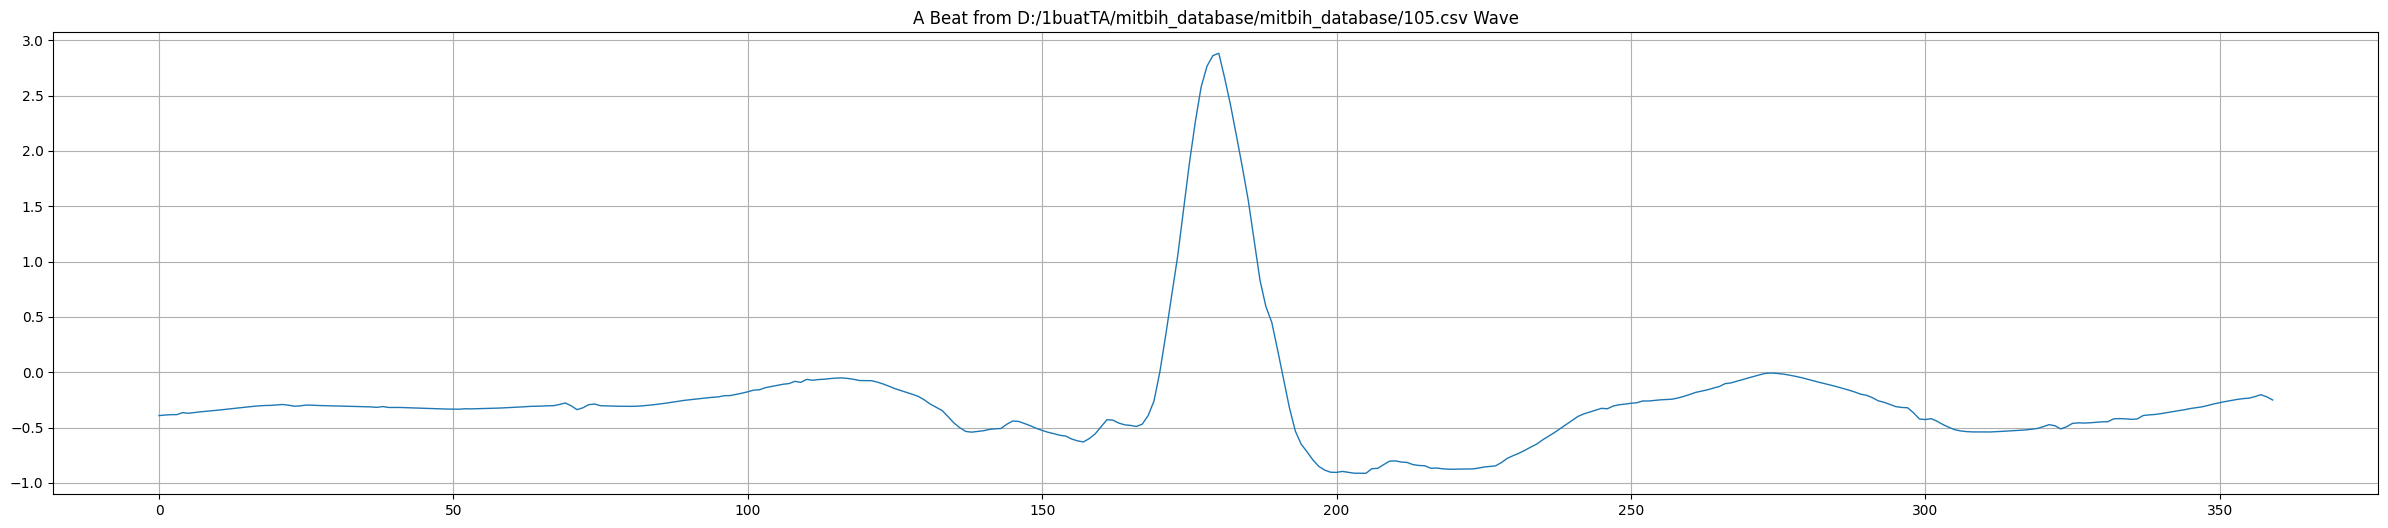

(100012, 360) (100012,)


In [48]:
# for each records
for r in range(0,len(records)):
    signals = []
    

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # read ECG data from .csv
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1
            
  #example plot of a sample 105.csv
    if r == 5:
        # Plot each patient's signal
        plt.title(records[5] + " Wave")
        plt.plot(signals[0:500])
        #plt.grid(False)
        plt.show()
        
    signals = denoise(signals) #denoising the signal
    # plotting after denoising
    if r == 5:
        plt.title(records[5] + " wave after denoised")
        plt.plot(signals[0:500])
        plt.show()
        
    signals = stats.zscore(signals) #performing Z score normalisation
    # Plot an example to the signals
    if r == 5:
        plt.title( records[5] + " wave after z-score normalization" )
        plt.plot(signals[0:500])
        plt.show()
    
    # Reading the R peaks and the annotation classes for each sample
    example_beat_printed = False
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines() 
        beat = list()

        for d in range(1, len(data)): 
            splitted = data[d].split(' ')
            splitted = filter(None, splitted)
            next(splitted) 
            pos = int(next(splitted))
            arrhythmia_type = next(splitted) # arrhythmia clas
            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)

                count_classes[arrhythmia_index] += 1
                if(window_size <= pos and pos < (len(signals) - window_size)):
                    beat = signals[pos-window_size:pos+window_size]  #R peaks  
                     
                    if r == 5 and not example_beat_printed: 
                        plt.title("A Beat from " + records[5] + " Wave")
                        plt.plot(beat)
                        plt.show()
                        example_beat_printed = True

                    X.append(beat)
                    y.append(arrhythmia_index)

print(np.shape(X), np.shape(y))


In [49]:
for i in range(0,len(X)):
        X[i] = np.append(X[i], y[i])

print(np.shape(X)) #combining X and y to a single file

(100012, 361)


#Distribusi Kelas

0.0    75011
1.0     8071
2.0     7255
4.0     7129
3.0     2546
Name: 360, dtype: int64


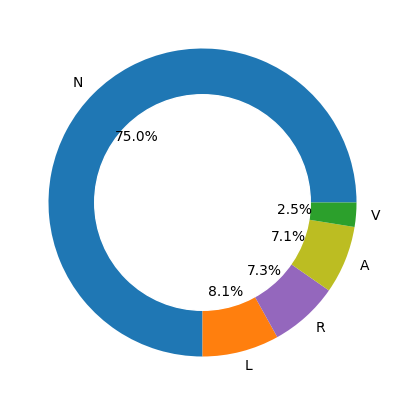

In [50]:
df = pd.DataFrame(X) #Array to df
per_class = df[df.shape[1]-1].value_counts() #class distribution
print(per_class)

#visualizing class distribution
plt.figure(figsize=(5,5))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

#Train-Test split

In [52]:
train,test=train_test_split(df,test_size=0.20) #train test split from the main dataframe
print("train : ", np.shape(train)) #train data shape
print("test  : ", np.shape(test)) #test data shape

train :  (80009, 361)
test  :  (20003, 361)


#Sampling Train Data

In [53]:
#down sampling class 0
df_0=(train[train[train.shape[1]-1]==0]).sample(7000,random_state=42)

#up sampling class 1
df_1=train[train[train.shape[1]-1]==1]
df_1_upsample=resample(df_1,replace=True,n_samples=7000,random_state=23)

#up sampling class 2
df_2=train[train[train.shape[1]-1]==2]
df_2_upsample=resample(df_2,replace=True,n_samples=7000,random_state=23)

#up sampling class 3
df_3=train[train[train.shape[1]-1]==3]
df_3_upsample=resample(df_3,replace=True,n_samples=7000,random_state=23)

#up sampling class 4
df_4=train[train[train.shape[1]-1]==4]
df_4_upsample=resample(df_4,replace=True,n_samples=7000,random_state=23)


In [54]:
train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])
#combining the sampled classes 

0.0    7000
1.0    7000
2.0    7000
3.0    7000
4.0    7000
Name: 360, dtype: int64


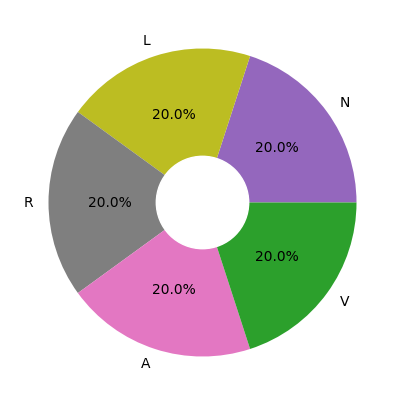

In [55]:
per_class = train_df[train_df.shape[1]-1].value_counts()
print(per_class)
#visualizing the sampled training data
plt.figure(figsize=(5,5))
my_circle=plt.Circle( (0,0), 0.3, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:purple','tab:olive','tab:grey','tab:pink','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
#plt.title("Sampling in train data")
plt.show()

In [56]:
train_df.shape #sampled training data shape

(35000, 361)

In [57]:
per_class = train_df[train_df.shape[1]-1].value_counts()
per_class #checking the sampled train data class distribution


0.0    7000
1.0    7000
2.0    7000
3.0    7000
4.0    7000
Name: 360, dtype: int64

#Independent and Dependent variables in Test Data 

In [58]:
#test data #hided from the model till evaluation
test_x= test.iloc[:,:test.shape[1]-1].values
test_x=test_x.reshape(len(test_x), test_x.shape[1],1) #reshaping to fit deep learning models
test_y= test[test.shape[1]-1] 
test_y=to_categorical(test_y) #one hot encoding

In [59]:
print("test_x : ", np.shape(test_x)) #independent variables of test data
print("test_y  : ", np.shape(test_y)) #dependent variables of test data

test_x :  (20003, 360, 1)
test_y  :  (20003, 5)


In [60]:
per_class = test[test.shape[1]-1].value_counts()
print(per_class)
# plt.figure(figsize=(5,5))
# #visualize test data class distribution
# my_circle=plt.Circle( (0,0), 0.3, color='white')
# plt.pie(per_class, labels=['N', 'S', 'V', 'F', 'Q'], colors=['tab:purple','tab:olive','tab:grey','tab:pink','tab:green'],autopct='%1.1f%%')
# p=plt.gcf()
# p.gca().add_artist(my_circle)
# plt.title("No sampling in test data")
# plt.show()

0.0    15003
1.0     1644
2.0     1460
4.0     1367
3.0      529
Name: 360, dtype: int64


#Independent and dependent varibale in Training Data

In [61]:
target_train=train_df[train_df.shape[1]-1] #label train
#target_val=val[val.shape[1]-1] #labes test
train_y=to_categorical(target_train)
#val_y=to_categorical(target_val)
print(np.shape(train_y))

(35000, 5)


In [62]:
train_x = train_df.iloc[:,:train_df.shape[1]-1].values
#val_x = val.iloc[:,:val.shape[1]-1].values
train_x = train_x.reshape(len(train_x), train_x.shape[1],1)
#val_x = val_x.reshape(len(val_x), val_x.shape[1],1)
print(np.shape(train_x))

(35000, 360, 1)


In [63]:
print("train_x : ", np.shape(train_x)) #independent variables in test data
print("train_y  : ", np.shape(train_y)) #dependent variable in test data
#print("val x : ", np.shape(val_x))
#print("val y  : ", np.shape(val_y))

train_x :  (35000, 360, 1)
train_y  :  (35000, 5)


#CNN Model

In [64]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, KFold
import sklearn.metrics as metrics

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 360, 16)           224       
                                                                 
 average_pooling1d_12 (Avera  (None, 179, 16)          0         
 gePooling1D)                                                    
                                                                 
 conv1d_13 (Conv1D)          (None, 179, 32)           7712      
                                                                 
 average_pooling1d_13 (Avera  (None, 89, 32)           0         
 gePooling1D)                                                    
                                                                 
 conv1d_14 (Conv1D)          (None, 89, 64)            34880     
                                                                 
 average_pooling1d_14 (Avera  (None, 44, 64)          

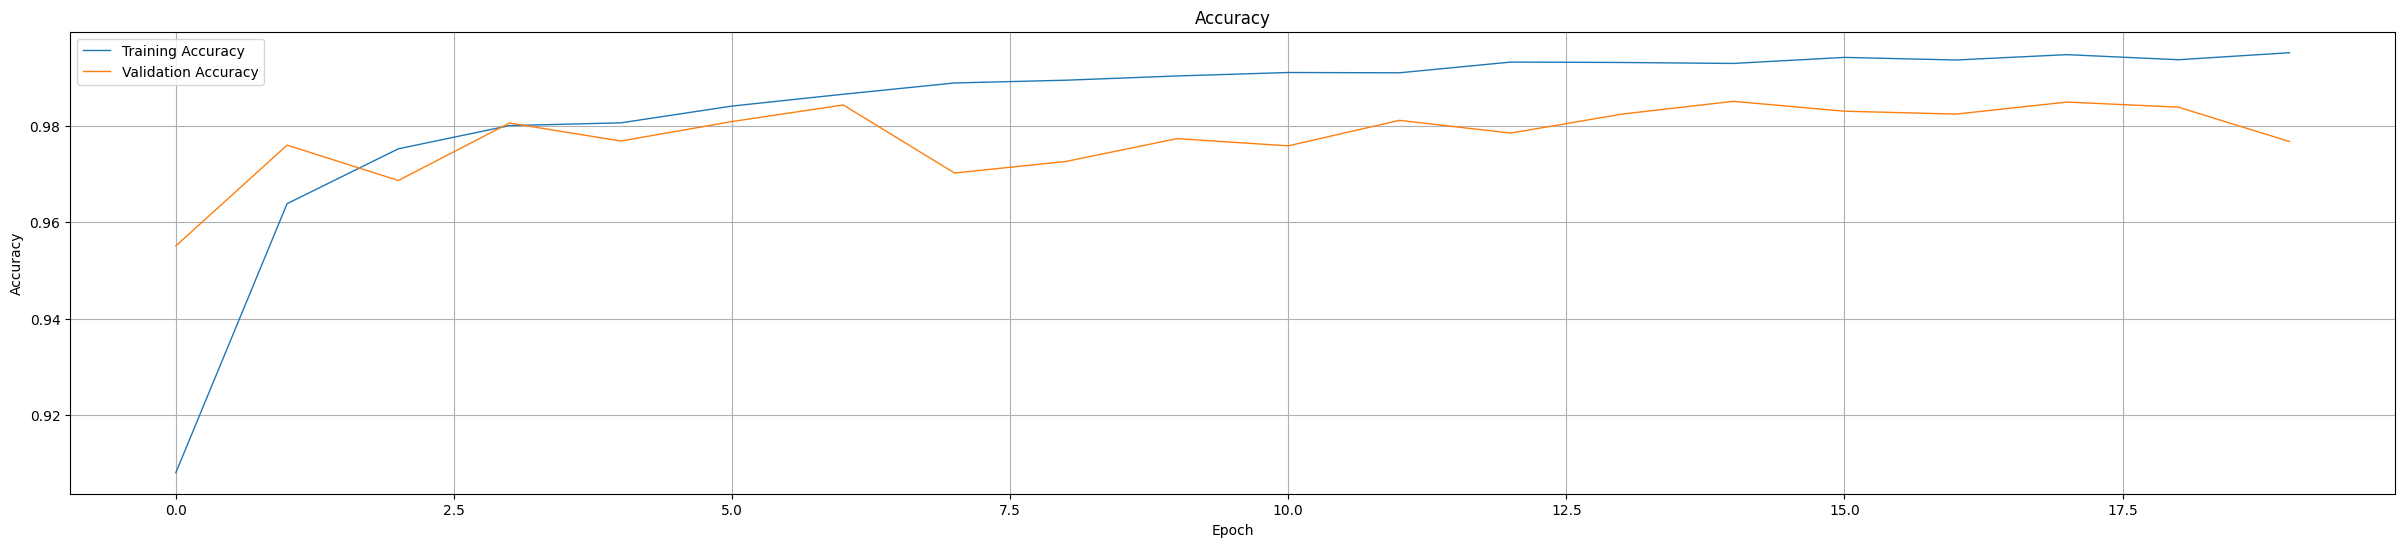

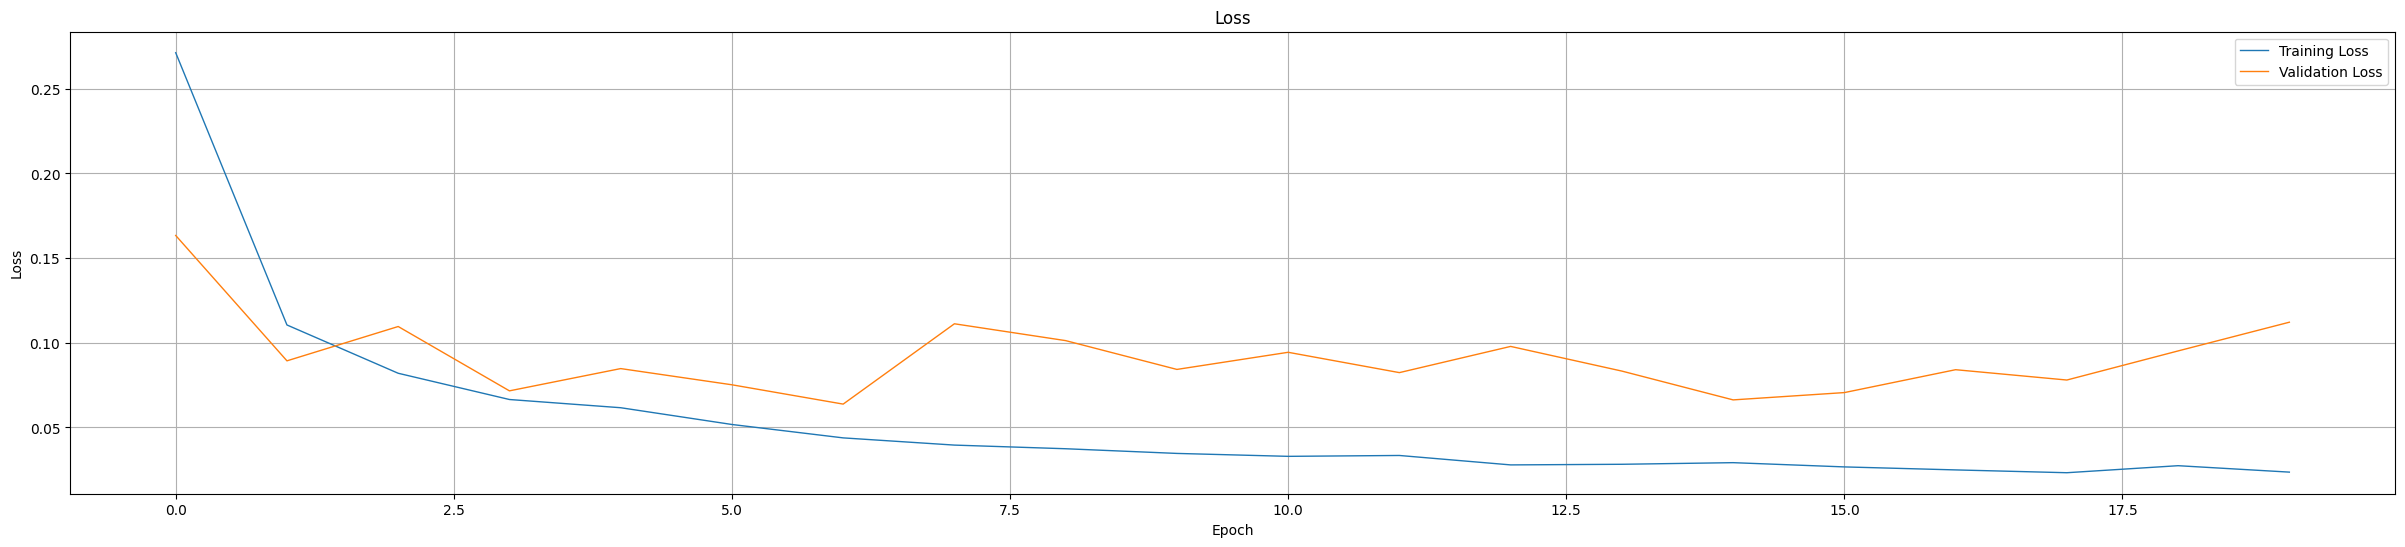

In [71]:
def cnn_model(): 
  model = Sequential()
  #convolution layer 1
  model.add(Conv1D(filters=16, kernel_size=13, padding='same', activation='relu',input_shape=(360, 1)))
  model.add(AvgPool1D(pool_size=3, strides=2))
  #convoulution layer 2
  model.add(Conv1D(filters=32, kernel_size=15, padding='same', activation='relu'))
  model.add(AvgPool1D(pool_size=3, strides=2))
  #convolution layer 3
  model.add(Conv1D(filters=64, kernel_size=17, padding='same', activation='relu'))
  model.add(AvgPool1D(pool_size=3, strides=2))
  #convolution layer 4
  model.add(Conv1D(filters=128, kernel_size=19, padding='same', activation='relu'))
  model.add(AvgPool1D(pool_size=3, strides=2))
  #flattening layer 
  model.add(Flatten())
  #Droupout threshold 0.5
  model.add(Dropout(0.5))
  #outer dense layer with 5 neurons represent 5 classes
  model.add(Dense(5,kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.l2(0.0001)))
  model.add(Softmax()) #probability of the classes
    
  model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
  model.summary()

  return model

cnn=cnn_model()

# Train the model
history = cnn.fit(train_x,train_y,validation_data=(test_x,test_y), batch_size=32, epochs=20)

# Plot accuracy values
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss values
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


##CNN model plot

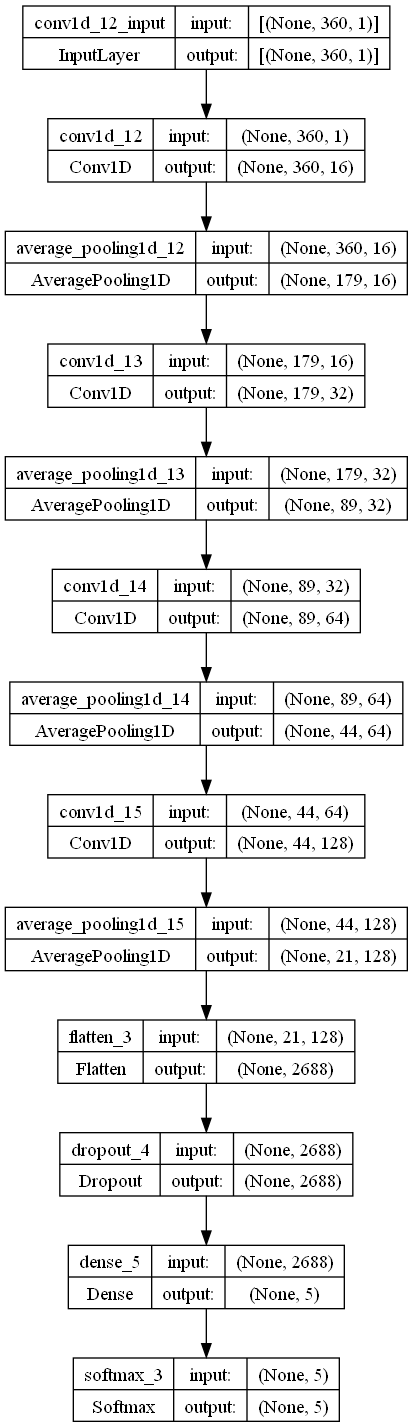

In [72]:
from keras.utils.vis_utils import plot_model
plot_model(cnn, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

##KFold cross validation

Fold #1
219/219 [==============================] - 2s 6ms/step
Fold score (RMSE): 0.05734771117568016
Score for fold 1: loss of 0.02134629897773266; accuracy of 100.0%
Fold #2
219/219 [==============================] - 1s 7ms/step
Fold score (RMSE): 0.022181548178195953
Score for fold 2: loss of 0.009266284294426441; accuracy of 100.0%
Fold #3
219/219 [==============================] - 1s 7ms/step
Fold score (RMSE): 0.028563814237713814
Score for fold 3: loss of 0.008955989964306355; accuracy of 100.0%
Fold #4
219/219 [==============================] - 2s 7ms/step
Fold score (RMSE): 0.02855066955089569
Score for fold 4: loss of 0.0082492521032691; accuracy of 100.0%
Fold #5
219/219 [==============================] - 1s 6ms/step
Fold score (RMSE): 0.01571759209036827
Score for fold 5: loss of 0.00754962582141161; accuracy of 100.0%


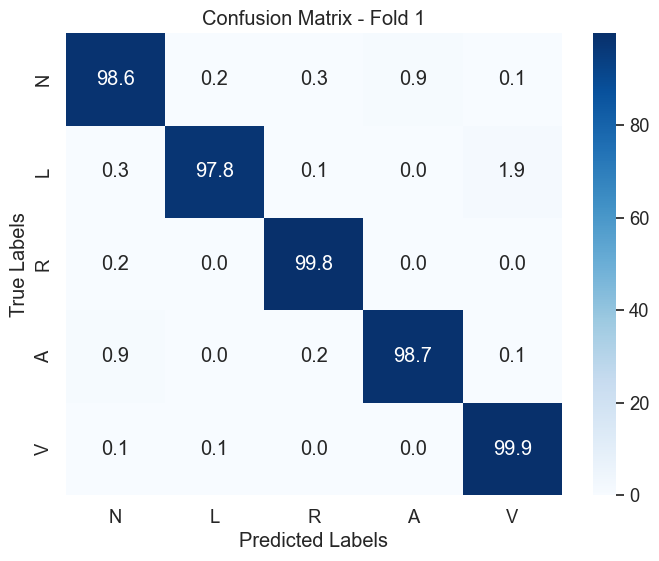

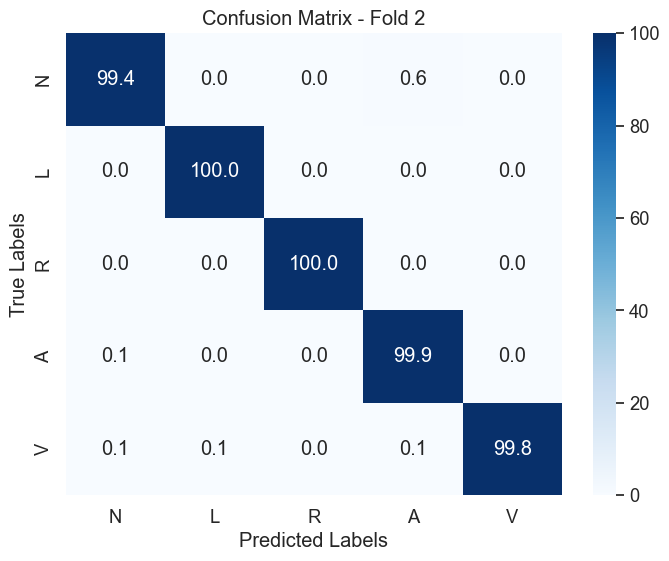

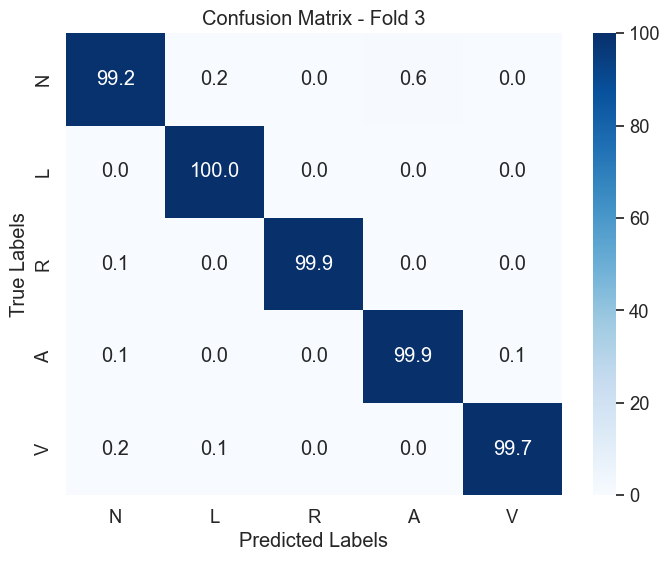

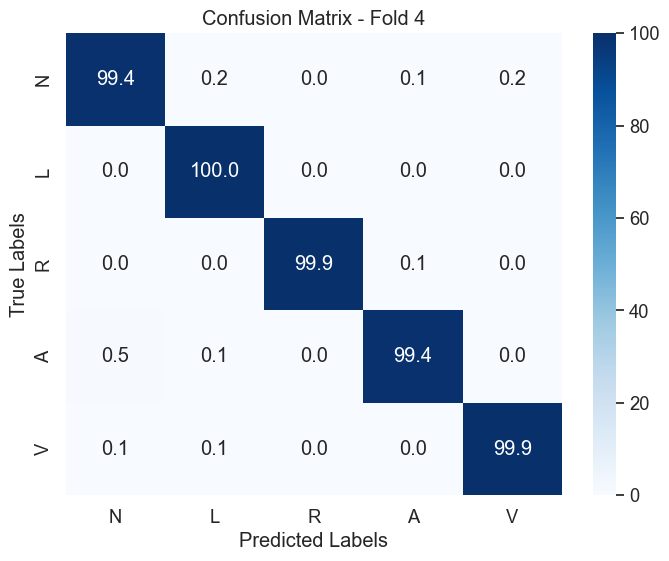

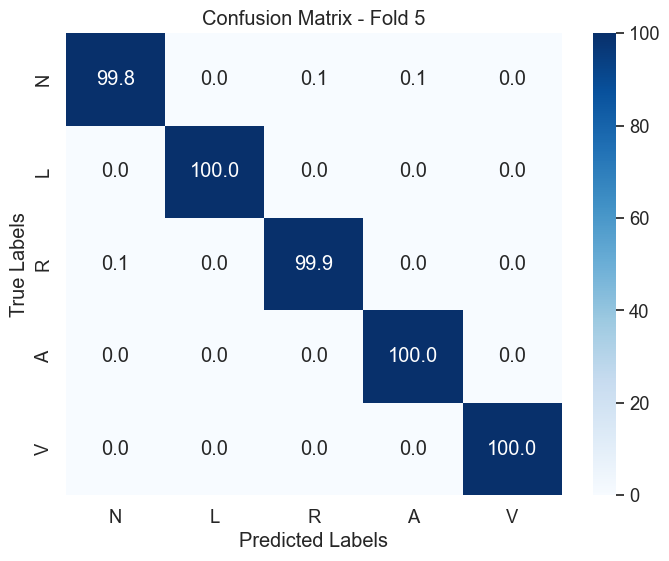

In [73]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

kf = KFold(5, shuffle=True, random_state=42)
oos_y = []
oos_pred = []

acc_per_fold = []
loss_per_fold = []
rmse_per_fold = []
conf_matrices = []  # List to store confusion matrices
fold = 0

for train, test in kf.split(train_x, train_y):
    fold += 1
    print(f"Fold #{fold}")

    x_train = train_x[train]
    y_train = train_y[train]
    x_test = train_x[test]
    y_test = train_y[test]

    history = cnn.fit(x_train, y_train, validation_data=(x_test, y_test), verbose=0, epochs=10)

    pred = cnn.predict(x_test)

    oos_y.append(y_test)
    oos_pred.append(pred)

    # Compute the confusion matrix
    cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(pred, axis=1))
    conf_matrices.append(cm)
    
    score = np.sqrt(metrics.mean_squared_error(pred, y_test))
    rmse_per_fold.append(score)
    print(f"Fold score (RMSE): {score}")

    scores = cnn.evaluate(x_test, pred, verbose=0)
    print(f'Score for fold {fold}: {cnn.metrics_names[0]} of {scores[0]}; {cnn.metrics_names[1]} of {scores[1] * 100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

# Print confusion matrices
class_names = ['N', 'L', 'R', 'A', 'V']
for fold, cm in enumerate(conf_matrices, start=1):
    rowcnn = cm.sum(axis=1, keepdims=True)
    cmp = (cm/ rowcnn) * 100
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(cmp, annot=True, fmt='.1f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - Fold {fold}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

In [133]:
conf_matrices

[array([[1385,    3,    4,   12,    1],
        [   4, 1366,    1,    0,   26],
        [   3,    0, 1399,    0,    0],
        [  13,    0,    3, 1398,    2],
        [   1,    1,    0,    0, 1378]], dtype=int64),
 array([[1405,    0,    0,    8,    0],
        [   0, 1436,    0,    0,    0],
        [   0,    0, 1362,    0,    0],
        [   1,    0,    0, 1341,    0],
        [   1,    1,    0,    1, 1444]], dtype=int64),
 array([[1346,    3,    0,    8,    0],
        [   0, 1367,    0,    0,    0],
        [   1,    0, 1421,    0,    0],
        [   1,    0,    0, 1430,    1],
        [   3,    1,    0,    0, 1418]], dtype=int64),
 array([[1398,    3,    0,    2,    3],
        [   0, 1424,    0,    0,    0],
        [   0,    0, 1398,    1,    0],
        [   7,    1,    0, 1404,    0],
        [   1,    1,    0,    0, 1357]], dtype=int64),
 array([[1416,    0,    1,    2,    0],
        [   0, 1376,    0,    0,    0],
        [   1,    0, 1414,    0,    0],
        [   0,    0,

In [74]:
average_acc=sum(acc_per_fold)/5 #to find average accuracy across 5 folds 
average_loss=sum(loss_per_fold)/5 #to find average loss across 5 folds
average_rmse=sum(rmse_per_fold)/5 # to find average rmse across 5 folds


##Training data Evaluation summary

In [75]:
average_acc

100.0

In [76]:
average_loss

0.011073490232229232

In [77]:
average_rmse

0.03047226704657078

In [79]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

y_true=[]
for element in train_y:
    y_true.append(np.argmax(element))
prediction_proba=cnn.predict(train_x)
prediction=np.argmax(prediction_proba,axis=1)

# Calculate the confusion matrix
model_cf_matrix = confusion_matrix(y_true, prediction)

# Calculate specificity for each class
specificity_per_class = []
for i in range(len(classes)):
    tn = np.sum(np.delete(model_cf_matrix, i, axis=0)[:, np.delete(np.arange(len(classes)), i)])
    fp = np.sum(model_cf_matrix[:, i]) - model_cf_matrix[i, i]
    specificity = tn / (tn + fp)
    specificity_per_class.append(specificity)

# Print classification report
print("Classification Report:")
print(classification_report(y_true, prediction, target_names=classes, digits=4))

# Print specificity for each class
for i, class_name in enumerate(classes):
    print(f"Specificity for class {class_name}: {specificity_per_class[i]:.4f}")


1094/1094 [==============================] - 7s 6ms/step
Classification Report:
              precision    recall  f1-score   support

           N     0.9996    0.9990    0.9993      7000
           L     1.0000    0.9997    0.9999      7000
           R     0.9999    0.9999    0.9999      7000
           A     0.9993    1.0000    0.9996      7000
           V     0.9999    1.0000    0.9999      7000

    accuracy                         0.9997     35000
   macro avg     0.9997    0.9997    0.9997     35000
weighted avg     0.9997    0.9997    0.9997     35000

Specificity for class N: 0.9999
Specificity for class L: 1.0000
Specificity for class R: 1.0000
Specificity for class A: 0.9998
Specificity for class V: 1.0000


1094/1094 [==============================] - 6s 6ms/step


<Axes: >

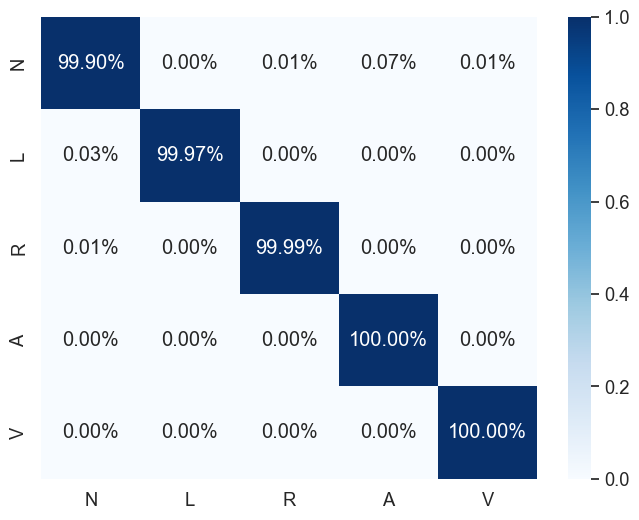

In [80]:
y_pred_cnn = cnn.predict(train_x)
y_pred_classes_cnn = np.argmax(y_pred_cnn, axis=1)
y_train_classes_cnn = np.argmax(train_y, axis=1)
cm_cnntrain = confusion_matrix(y_train_classes_cnn, y_pred_classes_cnn)
cm_ptrain = cm_cnntrain.astype('float') / cm_cnntrain.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm_ptrain, annot=True, fmt='.2%', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

In [81]:
TP_tcnn = cm_cnntrain[0][0]
FP_tcnn = cm_cnntrain[0][1]
FN_tcnn = cm_cnntrain[1][0]
TN_tcnn = cm_cnntrain[1][1]

accuracy_tcnn = (TP_tcnn+TN_tcnn) / (TP_tcnn+FP_tcnn+FN_tcnn+TN_tcnn)
specificity_tcnn = TN_tcnn / (TN_tcnn + FP_tcnn)
sensitivity_tcnn = TP_tcnn / (TP_tcnn + FN_tcnn)

print("Specificity:", specificity_tcnn)

Specificity: 1.0


##CNN Test Data Evaluation

###Test Loss and Accuracy

In [82]:
score = cnn.evaluate(test_x, test_y) #evaluating the models with the test data

print('Test Loss:', score[0])
print('Test accuracy:', score[1])

626/626 [==============================] - 4s 6ms/step - loss: 0.0947 - accuracy: 0.9849
Test Loss: 0.09472008794546127
Test accuracy: 0.9848522543907166


In [83]:
y_pred = cnn.predict(test_x, batch_size=1000) #predictions from the cnn model 

21/21 [==============================] - 3s 135ms/step


###Test Data classification report

###Test Data Confusion Matrix

In [89]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

y_true=[]
for element in test_y:
    y_true.append(np.argmax(element))
prediction_proba=cnn.predict(test_x)
prediction=np.argmax(prediction_proba,axis=1)

# Calculate the confusion matrix
model_cf_matrix = confusion_matrix(y_true, prediction)

# Calculate specificity for each class
specificity_per_class = []
for i in range(len(classes)):
    tn = np.sum(np.delete(model_cf_matrix, i, axis=0)[:, np.delete(np.arange(len(classes)), i)])
    fp = np.sum(model_cf_matrix[:, i]) - model_cf_matrix[i, i]
    specificity = tn / (tn + fp)
    specificity_per_class.append(specificity)

# Print classification report
print("Classification Report:")
print(classification_report(y_true, prediction, target_names=classes, digits=4))

# Print specificity for each class
for i, class_name in enumerate(classes):
    print(f"Specificity for class {class_name}: {specificity_per_class[i]:.4f}")




626/626 [==============================] - 4s 7ms/step
Classification Report:
              precision    recall  f1-score   support

           N     0.9974    0.9837    0.9905     15003
           L     0.9891    0.9951    0.9921      1644
           R     0.9838    0.9966    0.9901      1460
           A     0.7481    0.9376    0.8322       529
           V     0.9603    0.9912    0.9755      1367

    accuracy                         0.9849     20003
   macro avg     0.9357    0.9808    0.9561     20003
weighted avg     0.9866    0.9849    0.9854     20003

Specificity for class N: 0.9924
Specificity for class L: 0.9990
Specificity for class R: 0.9987
Specificity for class A: 0.9914
Specificity for class V: 0.9970


In [90]:
y_pred_cnn = cnn.predict(test_x)
y_pred_classes_cnn = np.argmax(y_pred_cnn, axis=1)
y_test_classes_cnn = np.argmax(test_y, axis=1)
cm_cnn = confusion_matrix(y_test_classes_cnn, y_pred_classes_cnn)
print("Confusion Matrix:")
print(cm_cnn)

626/626 [==============================] - 4s 6ms/step
Confusion Matrix:
[[14758    17    17   160    51]
 [    7  1636     1     0     0]
 [    1     0  1455     4     0]
 [   24     0     4   496     5]
 [    6     1     2     3  1355]]


<Axes: >

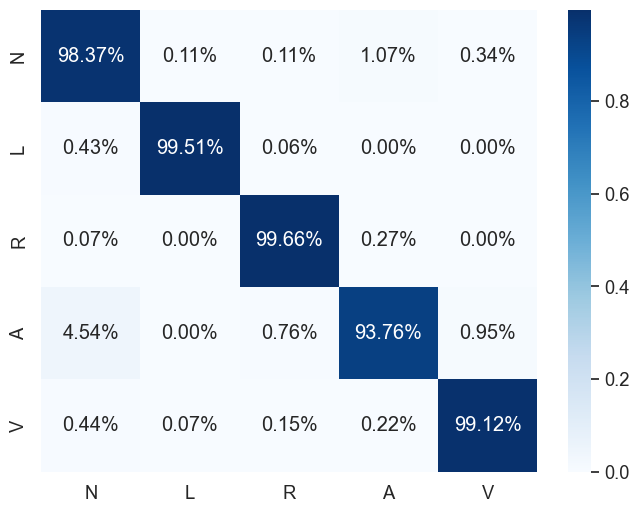

In [91]:
cm_ptest = cm_cnn.astype('float') / cm_cnn.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm_ptest, annot=True, fmt='.2%', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

In [92]:
TP_cnn = cm_cnn[0][0]
FP_cnn = cm_cnn[0][1]
FN_cnn = cm_cnn[1][0]
TN_cnn = cm_cnn[1][1]

accuracy_cnn = (TP_cnn+TN_cnn) / (TP_cnn+FP_cnn+FN_cnn+TN_cnn)
specificity_cnn = TN_cnn / (TN_cnn + FP_cnn)
sensitivity_cnn = TP_cnn / (TP_cnn + FN_cnn)

# print("Accuracy:", accuracy_cnn)
print("Specificity:", specificity_cnn)
# print("Sensitivity:", sensitivity_cnn)

Specificity: 0.9897156684815487


In [37]:
# Measure this RMSE
score = np.sqrt(metrics.mean_squared_error(y_true,prediction))
print(f"RMSE Score: {score}")

RMSE Score: 0.3521809127291063


#LSTM Model

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                16896     
                                                                 
 dense_6 (Dense)             (None, 128)               8320      
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 5)                 645       
                                                                 
Total params: 25,861
Trainable params: 25,861
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1094/1094 [==============================] - 154s 138ms/step - loss: 1.4236 - accuracy: 0.3869 - val_loss: 1.5233 - val_accuracy: 0.2016
Epoch 2/20
1094/1094 [============

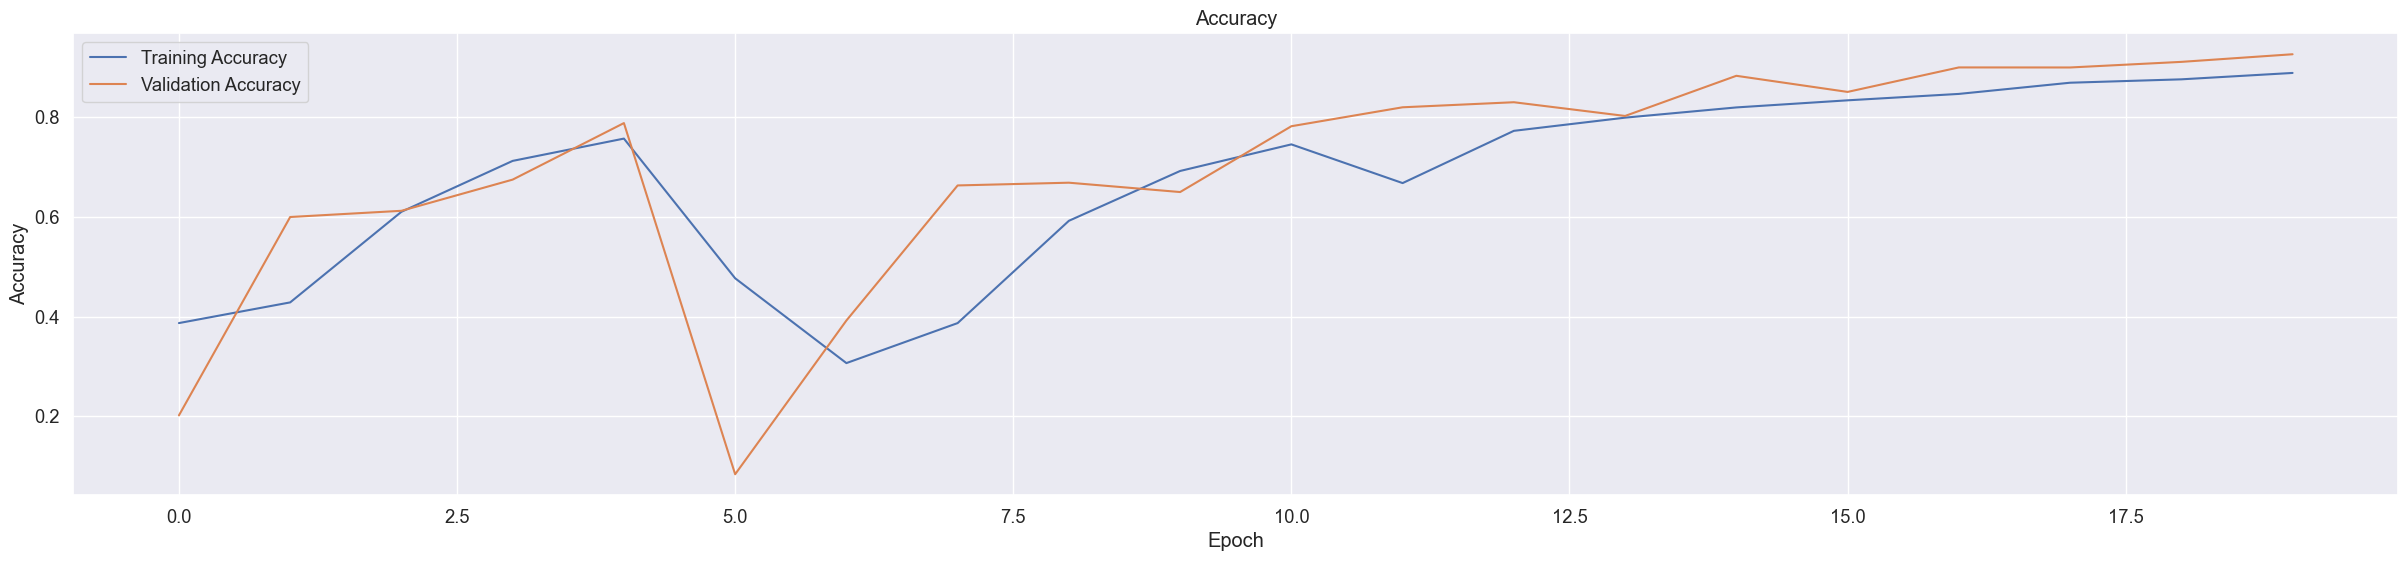

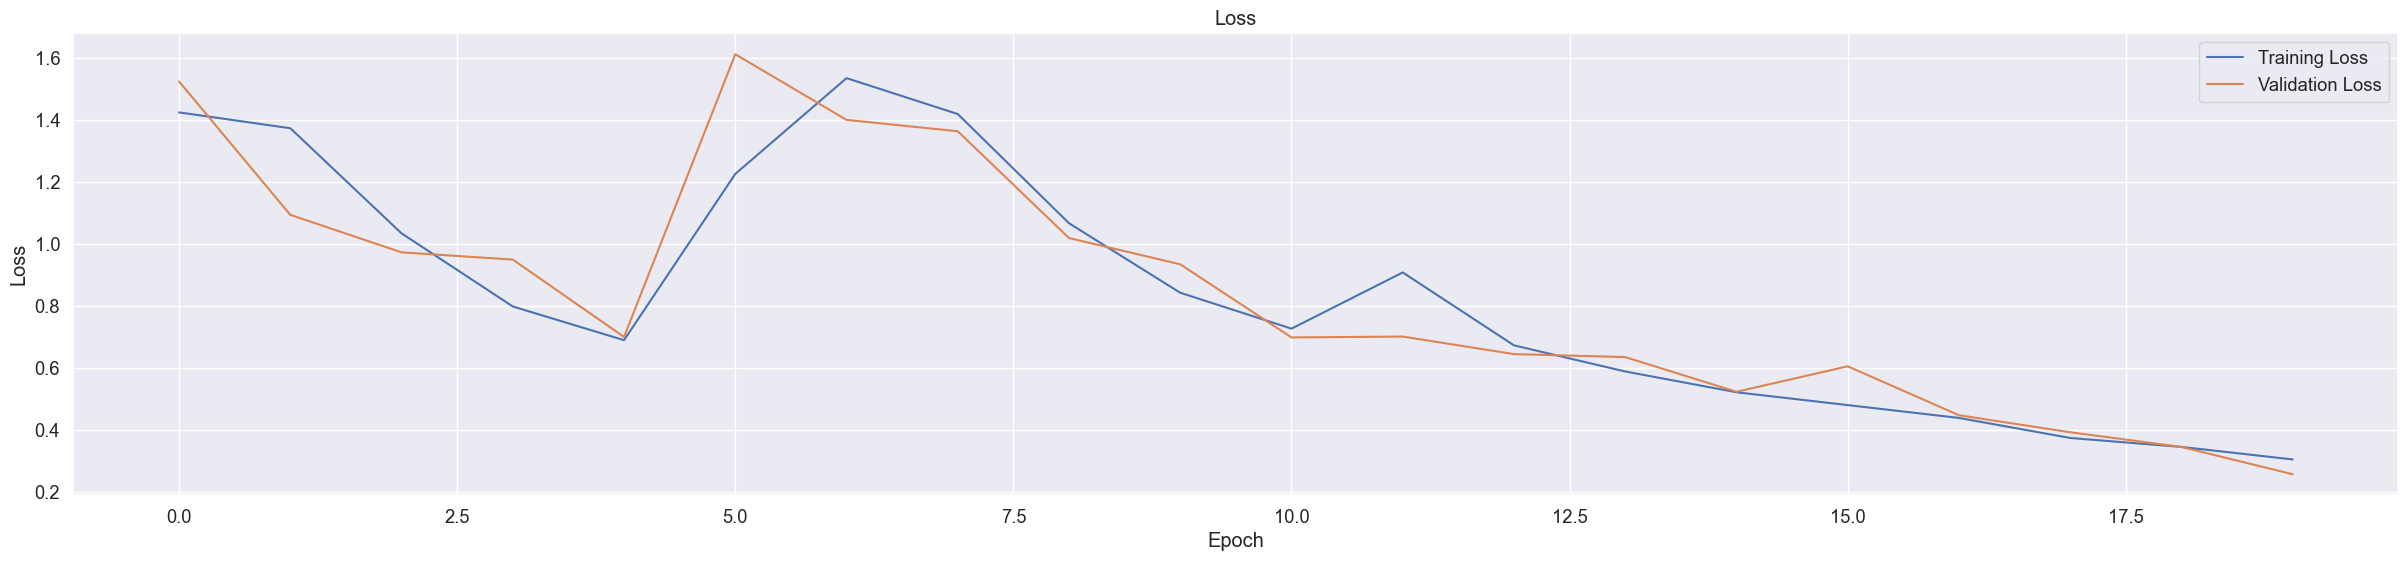

In [93]:
def get_lstm():
    lstm_model = Sequential()
    #one layer of LSTM
    lstm_model.add(LSTM(64, input_shape=(360,1)))
    #Fully connected dense layer
    lstm_model.add(Dense(128, activation = 'relu'))
    #dropout threshold 0.3
    lstm_model.add(Dropout(0.3))
    #outer dense layer with 5 neurons
    lstm_model.add(Dense(5, activation = 'softmax'))
    
    lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    lstm_model.summary()
    return lstm_model

lstm=get_lstm()

history = lstm.fit(train_x,train_y,validation_data=(test_x,test_y), batch_size=32, epochs=20)

# Plot accuracy values
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss values
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#LSTM model plot

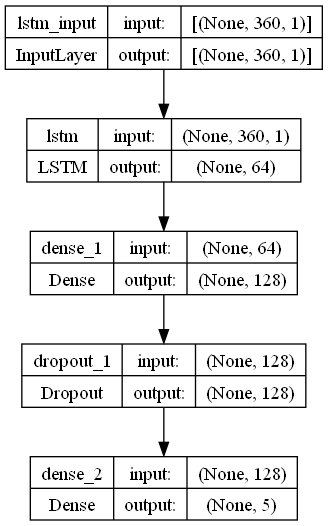

In [39]:
plot_model(lstm, to_file='lstm_plot.png', show_shapes=True, show_layer_names=True)

#KFold Cross Validation

Fold #1
219/219 [==============================] - 11s 49ms/step
Fold score (RMSE): 0.1268124133348465
Score for fold 1: loss of 0.11978095024824142; accuracy of 100.0%
Fold #2
219/219 [==============================] - 11s 50ms/step
Fold score (RMSE): 0.10247233510017395
Score for fold 2: loss of 0.08860496431589127; accuracy of 100.0%
Fold #3
219/219 [==============================] - 11s 48ms/step
Fold score (RMSE): 0.08762891590595245
Score for fold 3: loss of 0.06414224952459335; accuracy of 100.0%
Fold #4
219/219 [==============================] - 11s 48ms/step
Fold score (RMSE): 0.07896623760461807
Score for fold 4: loss of 0.061552345752716064; accuracy of 100.0%
Fold #5
219/219 [==============================] - 10s 46ms/step
Fold score (RMSE): 0.07662230730056763
Score for fold 5: loss of 0.05254112556576729; accuracy of 100.0%


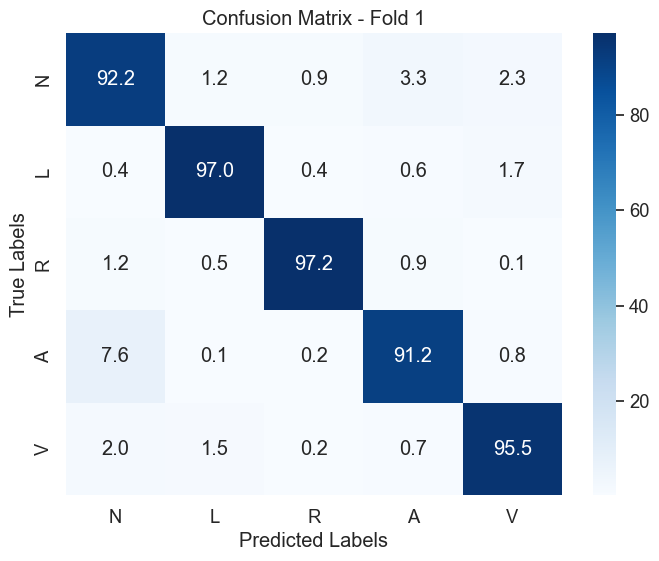

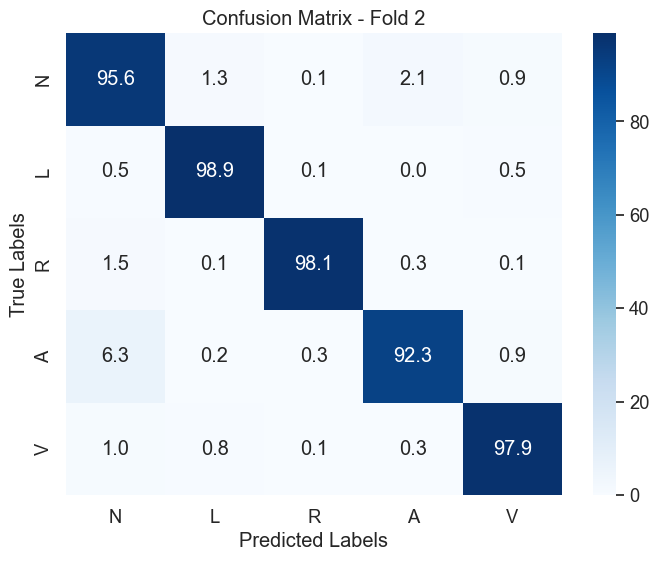

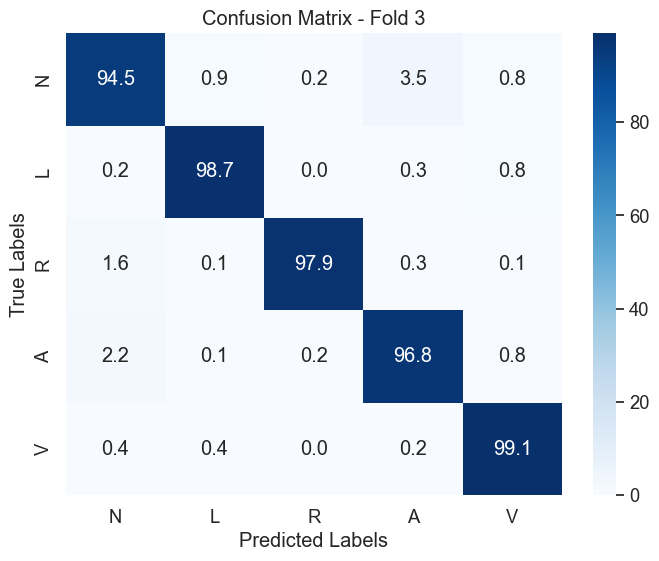

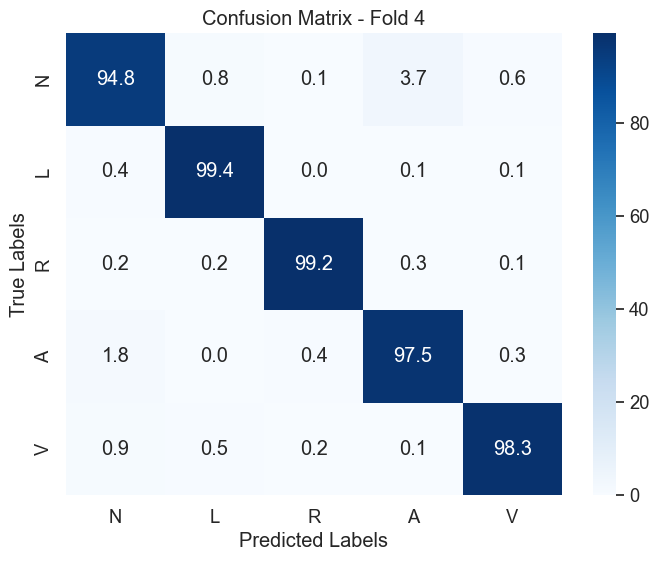

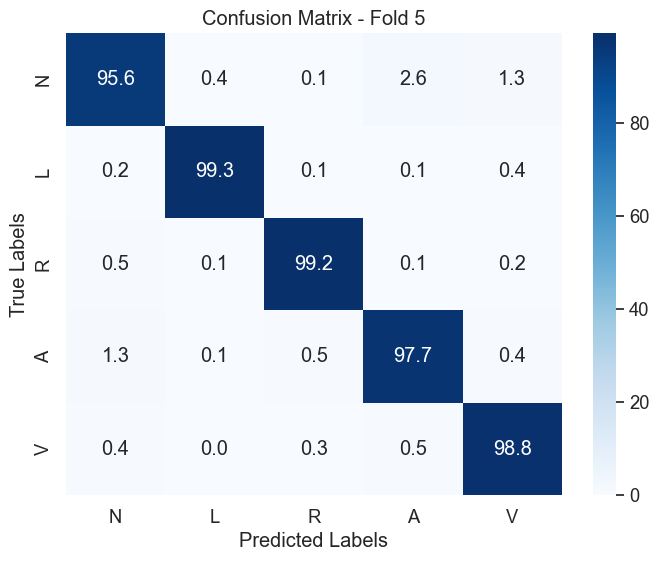

In [94]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold

kf = KFold(5, shuffle=True, random_state=42)
oos_y = []
oos_pred = []

lstm_acc_per_fold = []
lstm_loss_per_fold = []
lstm_rmse_per_fold = []
lstm_conf_matrices = []  # List to store confusion matrics
fold = 0

for train, test in kf.split(train_x, train_y):
    fold += 1
    print(f"Fold #{fold}")

    x_train = train_x[train]
    y_train = train_y[train]
    x_test = train_x[test]
    y_test = train_y[test]

    history = lstm.fit(x_train, y_train, validation_data=(x_test, y_test), verbose=0, epochs=10)

    pred = lstm.predict(x_test)

    oos_y.append(y_test)
    oos_pred.append(pred)

    # Compute the confusion matrix
    cm_lstm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(pred, axis=1))
    lstm_conf_matrices.append(cm_lstm)
    # print(f"Confusion matrix for Fold #{fold}:\n{cm_lstm}")
    
    score = np.sqrt(metrics.mean_squared_error(pred, y_test))
    lstm_rmse_per_fold.append(score)
    print(f"Fold score (RMSE): {score}")

    scores = lstm.evaluate(x_test, pred, verbose=0)
    print(f'Score for fold {fold}: {lstm.metrics_names[0]} of {scores[0]}; {lstm.metrics_names[1]} of {scores[1] * 100}%')
    lstm_acc_per_fold.append(scores[1] * 100)
    lstm_loss_per_fold.append(scores[0])

class_names = ['N', 'L', 'R', 'A', 'V']

for fold, cm_lstm in enumerate(lstm_conf_matrices, start=1):
    rowlstm = cm_lstm.sum(axis=1, keepdims=True)
    cmplstm = (cm_lstm/ rowlstm) * 100
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(cmplstm, annot=True, fmt='.1f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - Fold {fold}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

In [134]:
lstm_conf_matrices

[array([[1296,   17,   13,   47,   32],
        [   5, 1355,    5,    8,   24],
        [  17,    7, 1363,   13,    2],
        [ 107,    2,    3, 1292,   12],
        [  28,   21,    3,   10, 1318]], dtype=int64),
 array([[1351,   18,    1,   30,   13],
        [   7, 1420,    2,    0,    7],
        [  20,    1, 1336,    4,    1],
        [  85,    3,    4, 1238,   12],
        [  15,   11,    1,    4, 1416]], dtype=int64),
 array([[1283,   12,    3,   48,   11],
        [   3, 1349,    0,    4,   11],
        [  23,    1, 1392,    4,    2],
        [  31,    1,    3, 1386,   11],
        [   5,    5,    0,    3, 1409]], dtype=int64),
 array([[1333,   11,    1,   52,    9],
        [   6, 1415,    0,    1,    2],
        [   3,    3, 1388,    4,    1],
        [  26,    0,    6, 1376,    4],
        [  12,    7,    3,    1, 1336]], dtype=int64),
 array([[1356,    5,    2,   37,   19],
        [   3, 1366,    1,    1,    5],
        [   7,    1, 1403,    1,    3],
        [  18,    1,

## LSTM Train Evaluation

In [95]:
lstm_average_acc=sum(acc_per_fold)/5 #average of LSTM accuracy across 5 fold
lstm_average_loss=sum(loss_per_fold)/5 #average of LSTM loss across 5 fold
lstm_average_rmse=sum(rmse_per_fold)/5 #average of LSTM rmse across 5 fold

In [96]:
lstm_average_acc

100.0

In [98]:
lstm_average_loss

0.011073490232229232

In [99]:
lstm_average_rmse

0.03047226704657078

In [100]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

y_true=[]
for element in train_y:
    y_true.append(np.argmax(element))
prediction_proba=lstm.predict(train_x)
prediction=np.argmax(prediction_proba,axis=1)

# Calculate the confusion matrix
lstm_model_cf_matrix = confusion_matrix(y_true, prediction)

# Calculate specificity for each class
lstm_specificity_per_class = []
for i in range(len(classes)):
    tn = np.sum(np.delete(lstm_model_cf_matrix, i, axis=0)[:, np.delete(np.arange(len(classes)), i)])
    fp = np.sum(lstm_model_cf_matrix[:, i]) - lstm_model_cf_matrix[i, i]
    specificity = tn / (tn + fp)
    lstm_specificity_per_class.append(specificity)

# Print classification report
print("Classification Report:")
print(classification_report(y_true, prediction, target_names=classes, digits=4))

# Print specificity for each class
for i, class_name in enumerate(classes):
    print(f"Specificity for class {class_name}: {lstm_specificity_per_class[i]:.4f}")


1094/1094 [==============================] - 53s 48ms/step
Classification Report:
              precision    recall  f1-score   support

           N     0.9791    0.9619    0.9704      7000
           L     0.9953    0.9920    0.9936      7000
           R     0.9912    0.9951    0.9932      7000
           A     0.9736    0.9793    0.9764      7000
           V     0.9805    0.9913    0.9859      7000

    accuracy                         0.9839     35000
   macro avg     0.9839    0.9839    0.9839     35000
weighted avg     0.9839    0.9839    0.9839     35000

Specificity for class N: 0.9949
Specificity for class L: 0.9988
Specificity for class R: 0.9978
Specificity for class A: 0.9934
Specificity for class V: 0.9951


1094/1094 [==============================] - 52s 47ms/step


<Axes: >

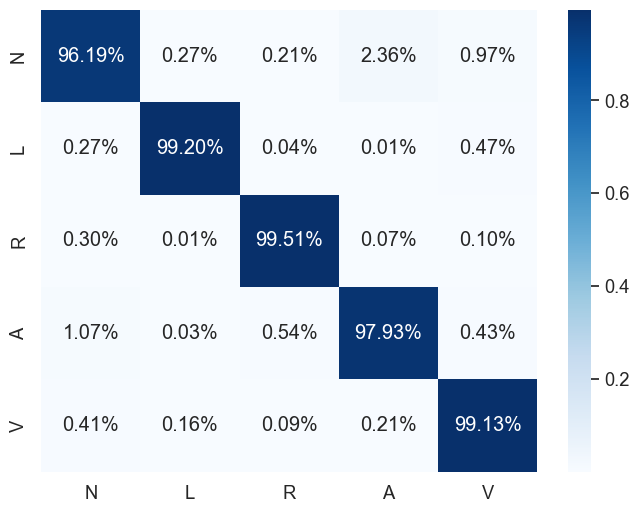

In [101]:
y_pred_lstm = lstm.predict(train_x)
y_pred_classes_lstm = np.argmax(y_pred_lstm, axis=1)
y_train_classes_lstm = np.argmax(train_y, axis=1)
cm_lstmtrain = confusion_matrix(y_train_classes_lstm, y_pred_classes_lstm)
cm_lstmptrain = cm_lstmtrain.astype('float') / cm_lstmtrain.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm_lstmptrain, annot=True, fmt='.2%', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

In [102]:
TP_tlstm = cm_lstmtrain[0][0]
FP_tlstm = cm_lstmtrain[0][1]
FN_tlstm = cm_lstmtrain[1][0]
TN_tlstm = cm_lstmtrain[1][1]

accuracy_tlstm = (TP_tlstm+TN_tlstm) / (TP_tlstm+FP_tlstm+FN_tlstm+TN_tlstm)
specificity_tlstm = TN_tlstm / (TN_tlstm + FP_tlstm)
sensitivity_tlstm = TP_tlstm / (TP_tlstm + FN_tlstm)

print("Specificity:", specificity_tcnn)

Specificity: 1.0


## LSTM Test Evaluation

In [103]:
score = lstm.evaluate(test_x, test_y) #evaluation of LSTM on test data

print('Test Loss:', score[0])
print('Test accuracy:', score[1])

626/626 [==============================] - 30s 48ms/step - loss: 0.1533 - accuracy: 0.9536
Test Loss: 0.1532677263021469
Test accuracy: 0.9535569548606873


In [104]:
y_pred = lstm.predict(test_x, batch_size=1000) #prediction by the LSTM model

21/21 [==============================] - 11s 531ms/step


In [105]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

y_true=[]
for element in test_y:
    y_true.append(np.argmax(element))
prediction_proba=lstm.predict(test_x)
prediction=np.argmax(prediction_proba,axis=1)

# Calculate the confusion matrix
model_cf_matrix = confusion_matrix(y_true, prediction)

# Calculate specificity for each class
specificity_per_class = []
for i in range(len(classes)):
    tn = np.sum(np.delete(model_cf_matrix, i, axis=0)[:, np.delete(np.arange(len(classes)), i)])
    fp = np.sum(model_cf_matrix[:, i]) - model_cf_matrix[i, i]
    specificity = tn / (tn + fp)
    specificity_per_class.append(specificity)

# Print classification report
print("Classification Report:")
print(classification_report(y_true, prediction, target_names=classes, digits=4))

# Print specificity for each class
for i, class_name in enumerate(classes):
    print(f"Specificity for class {class_name}: {specificity_per_class[i]:.4f}")


626/626 [==============================] - 30s 48ms/step
Classification Report:
              precision    recall  f1-score   support

           N     0.9956    0.9464    0.9704     15003
           L     0.9533    0.9805    0.9667      1644
           R     0.9482    0.9911    0.9692      1460
           A     0.4920    0.9244    0.6422       529
           V     0.8673    0.9707    0.9161      1367

    accuracy                         0.9536     20003
   macro avg     0.8513    0.9626    0.8929     20003
weighted avg     0.9666    0.9536    0.9576     20003

Specificity for class N: 0.9874
Specificity for class L: 0.9957
Specificity for class R: 0.9957
Specificity for class A: 0.9741
Specificity for class V: 0.9891


In [107]:
y_pred_lstm = lstm.predict(test_x)
y_pred_classes_lstm = np.argmax(y_pred_lstm, axis=1)
y_test_classes_lstm = np.argmax(test_y, axis=1)
cm_lstm = confusion_matrix(y_test_classes_lstm, y_pred_classes_lstm)
print("Confusion Matrix:")
print(cm_lstm)

626/626 [==============================] - 31s 50ms/step
Confusion Matrix:
[[14199    64    64   495   181]
 [   15  1612     3     2    12]
 [    8     2  1447     2     1]
 [   22     2     7   489     9]
 [   18    11     5     6  1327]]


<Axes: >

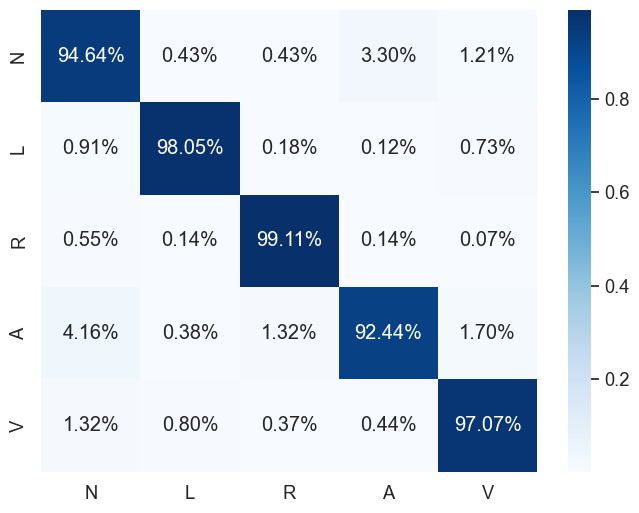

In [108]:
cm_lstmptest = cm_lstm.astype('float') / cm_lstm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm_lstmptest, annot=True, fmt='.2%', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

In [109]:
TP_lstm = cm_lstm[0][0]
FP_lstm = cm_lstm[0][1]
FN_lstm = cm_lstm[1][0]
TN_lstm = cm_lstm[1][1]

specificity_lstm = TN_lstm / (TN_lstm + FP_lstm)

print("Specificity:", specificity_lstm)

Specificity: 0.9618138424821002


In [110]:
score = np.sqrt(metrics.mean_squared_error(y_true,prediction))
print(f"RMSE Score: {score}")

RMSE Score: 0.6511039928756153


#GRU Model

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 64)                12864     
                                                                 
 dense_8 (Dense)             (None, 128)               8320      
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 5)                 645       
                                                                 
Total params: 21,829
Trainable params: 21,829
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1094/1094 [==============================] - 140s 124ms/step - loss: 1.5142 - accuracy: 0.3334 - val_loss: 1.5395 - val_accuracy: 0.1999
Epoch 2/20
1094/1094 [============

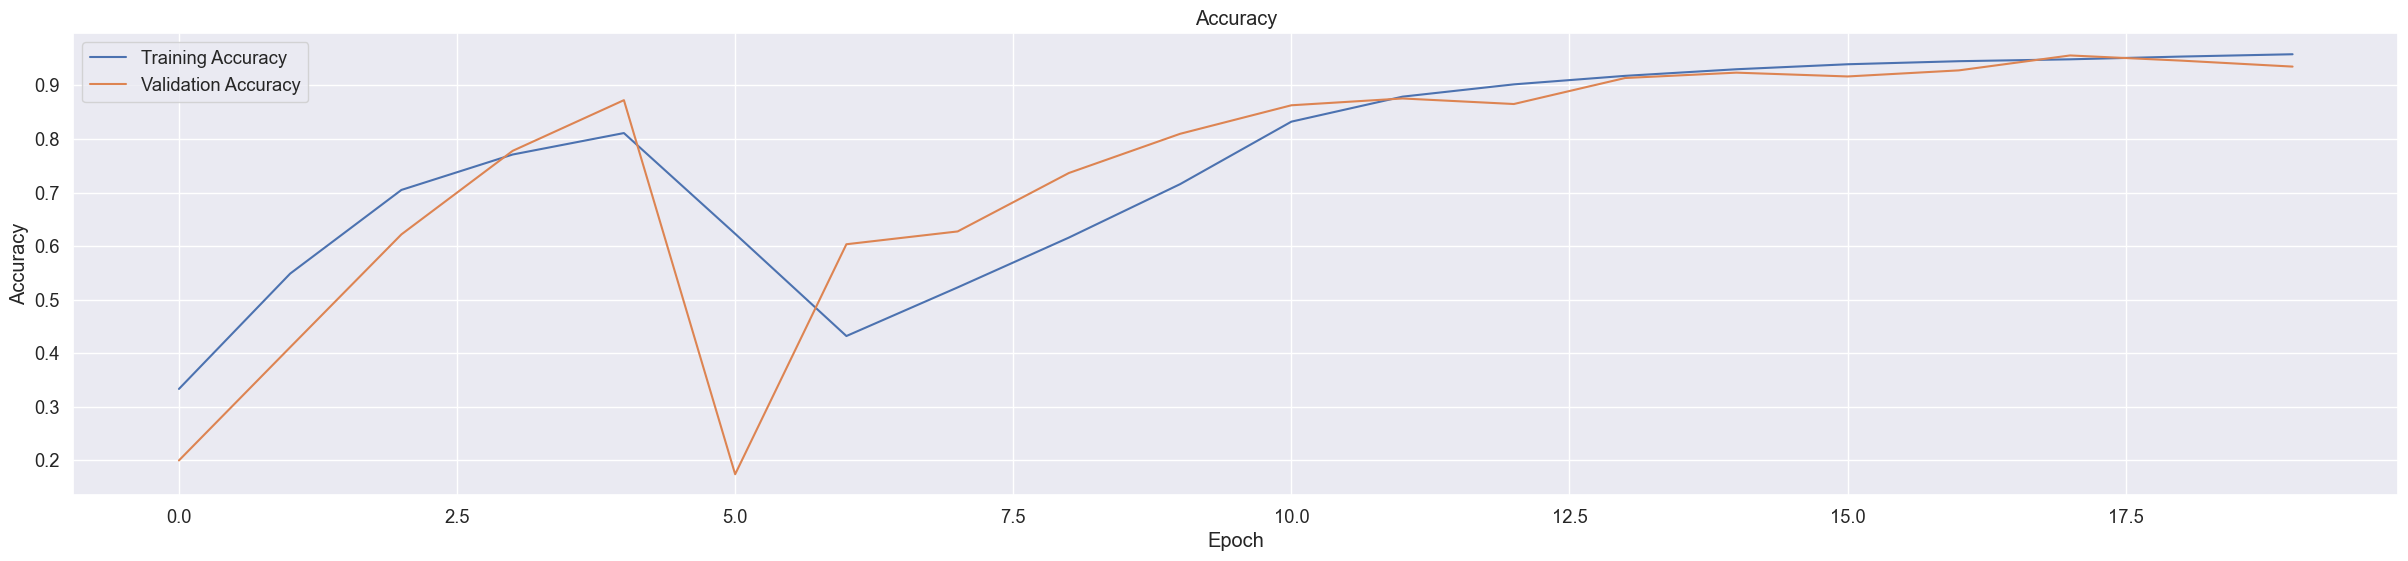

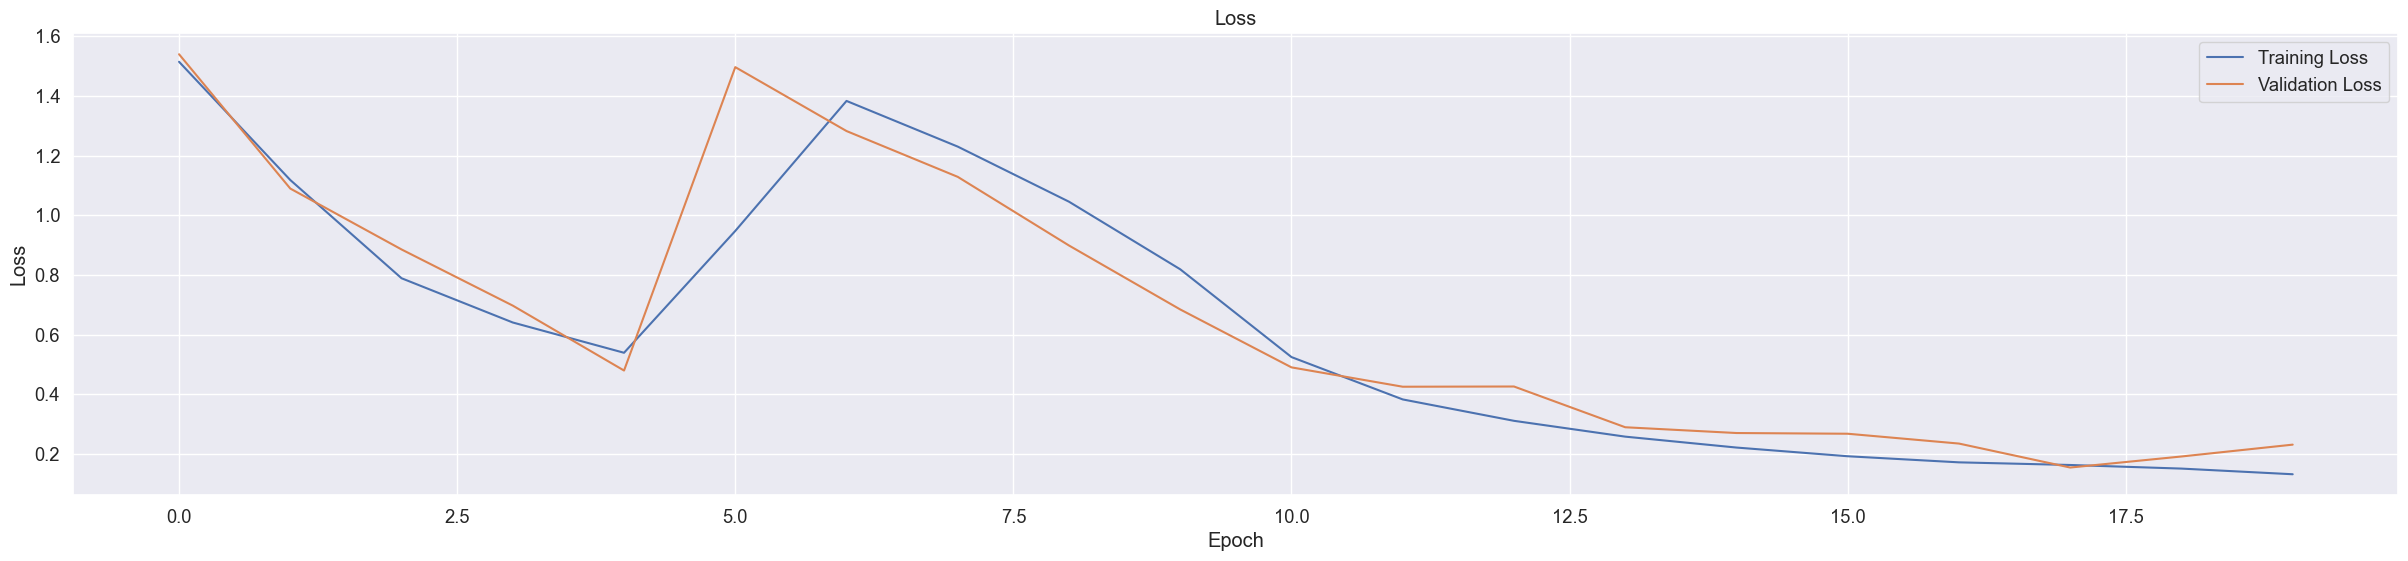

In [111]:
def get_gru():
    gru_model = Sequential()
    #single layer GRU
    gru_model.add(GRU(64, input_shape=(360,1)))
    #fully connected outer layer
    gru_model.add(Dense(128, activation = 'relu'))
    #droput threshold 0.3
    gru_model.add(Dropout(0.3))
    #outer layer with 5 neurons
    gru_model.add(Dense(5, activation = 'softmax'))
    
    gru_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    gru_model.summary()
    return gru_model

gru=get_gru()

history = gru.fit(train_x,train_y,validation_data=(test_x,test_y), batch_size=32, epochs=20)

# Plot accuracy values
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss values
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

##GRU Model Plot

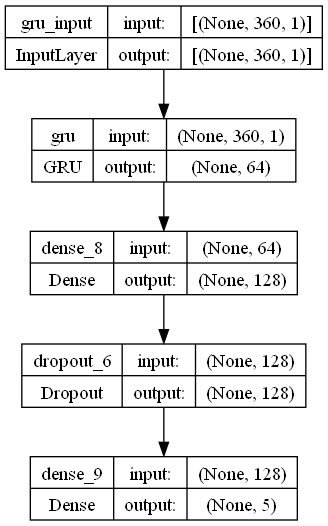

In [115]:
plot_model(gru, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## KFold cross Validation

Fold #1
219/219 [==============================] - 8s 33ms/step
Fold score (RMSE): 0.09958810359239578
Score for fold 1: loss of 0.06850165128707886; accuracy of 100.0%
Fold #2
219/219 [==============================] - 7s 33ms/step
Fold score (RMSE): 0.07246648520231247
Score for fold 2: loss of 0.045842770487070084; accuracy of 100.0%
Fold #3
219/219 [==============================] - 7s 33ms/step
Fold score (RMSE): 0.07129106670618057
Score for fold 3: loss of 0.035802677273750305; accuracy of 100.0%
Fold #4
219/219 [==============================] - 7s 34ms/step
Fold score (RMSE): 0.07316593825817108
Score for fold 4: loss of 0.03658086434006691; accuracy of 100.0%
Fold #5
219/219 [==============================] - 7s 33ms/step
Fold score (RMSE): 0.05182773247361183
Score for fold 5: loss of 0.02051088958978653; accuracy of 100.0%


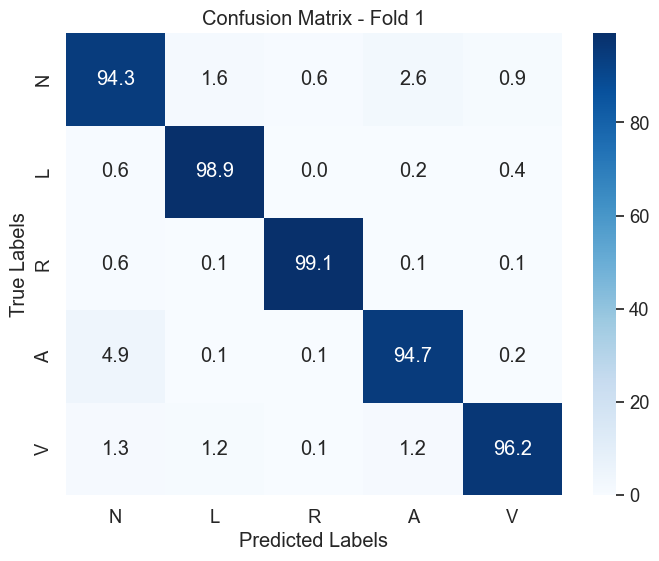

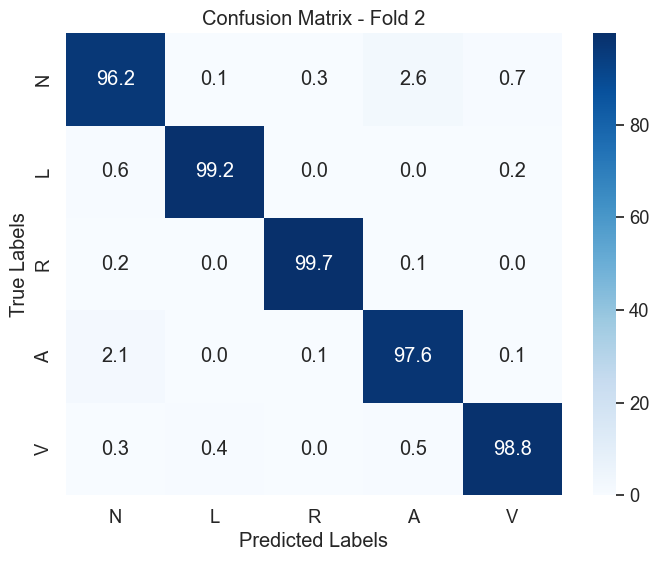

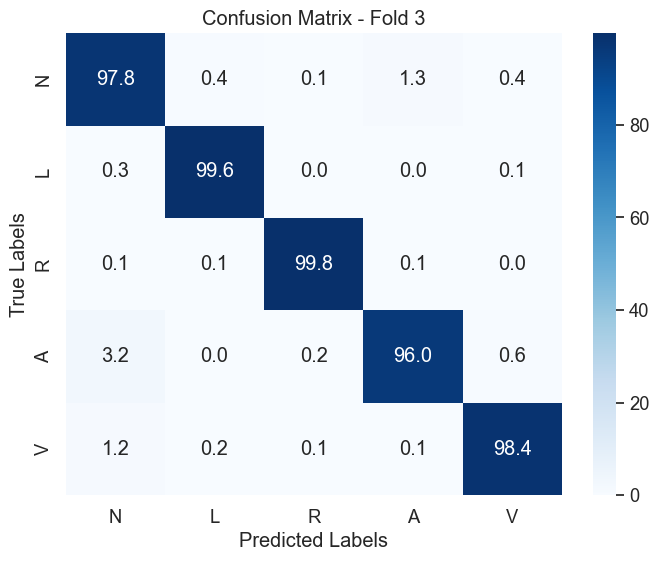

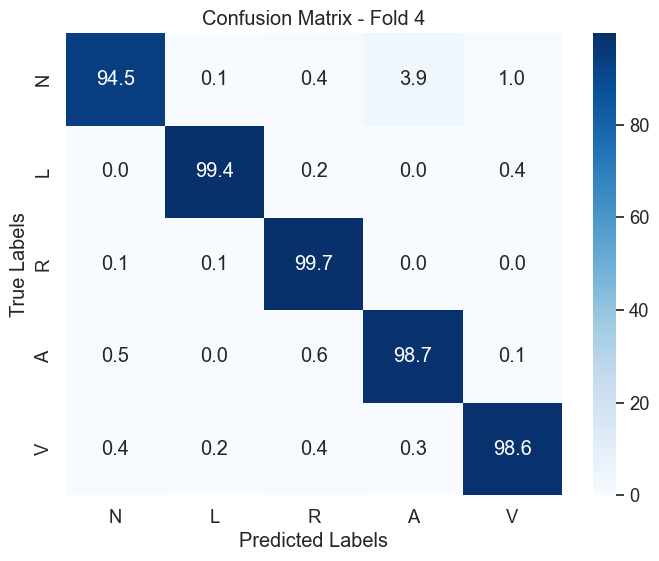

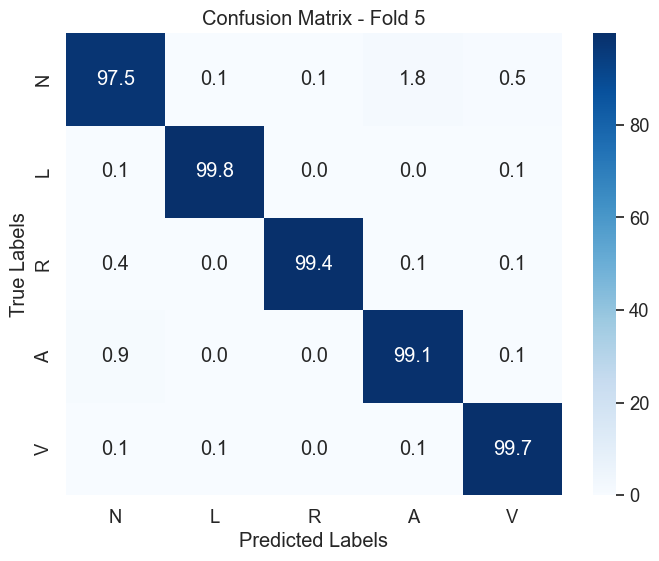

In [116]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold

kf = KFold(5, shuffle=True, random_state=42)
oos_y = []
oos_pred = []

gru_acc_per_fold = []
gru_loss_per_fold = []
gru_rmse_per_fold = []
gru_conf_matrices = []  # List to store confusion matrics
fold = 0

for train, test in kf.split(train_x, train_y):
    fold += 1
    print(f"Fold #{fold}")

    x_train = train_x[train]
    y_train = train_y[train]
    x_test = train_x[test]
    y_test = train_y[test]

    history = gru.fit(x_train, y_train, validation_data=(x_test, y_test), verbose=0, epochs=10)

    pred = gru.predict(x_test)

    oos_y.append(y_test)
    oos_pred.append(pred)

    # Compute the confusion matrix
    cm_gru = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(pred, axis=1))
    gru_conf_matrices.append(cm_gru)
    # print(f"Confusion matrix for Fold #{fold}:\n{cm_gru}")
    
    score = np.sqrt(metrics.mean_squared_error(pred, y_test))
    gru_rmse_per_fold.append(score)
    print(f"Fold score (RMSE): {score}")

    scores = gru.evaluate(x_test, pred, verbose=0)
    print(f'Score for fold {fold}: {gru.metrics_names[0]} of {scores[0]}; {gru.metrics_names[1]} of {scores[1] * 100}%')
    gru_acc_per_fold.append(scores[1] * 100)
    gru_loss_per_fold.append(scores[0])

class_names = ['N', 'L', 'R', 'A', 'V']

for fold, cm_gru in enumerate(gru_conf_matrices, start=1):
    rowgru = cm_gru.sum(axis=1, keepdims=True)
    cmpgru = (cm_gru/ rowgru) * 100
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(cmpgru, annot=True, fmt='.1f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - Fold {fold}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()
 

In [117]:
gru_conf_matrices

[array([[1325,   23,    8,   37,   12],
        [   8, 1381,    0,    3,    5],
        [   8,    1, 1390,    2,    1],
        [  70,    1,    1, 1341,    3],
        [  18,   16,    1,   17, 1328]], dtype=int64),
 array([[1360,    2,    4,   37,   10],
        [   9, 1424,    0,    0,    3],
        [   3,    0, 1358,    1,    0],
        [  28,    0,    2, 1310,    2],
        [   5,    6,    0,    7, 1429]], dtype=int64),
 array([[1327,    6,    2,   17,    5],
        [   4, 1362,    0,    0,    1],
        [   1,    1, 1419,    1,    0],
        [  46,    0,    3, 1375,    8],
        [  17,    3,    2,    1, 1399]], dtype=int64),
 array([[1329,    2,    6,   55,   14],
        [   0, 1415,    3,    0,    6],
        [   2,    2, 1395,    0,    0],
        [   7,    0,    9, 1394,    2],
        [   6,    3,    6,    4, 1340]], dtype=int64),
 array([[1383,    1,    2,   26,    7],
        [   2, 1373,    0,    0,    1],
        [   5,    0, 1407,    1,    2],
        [  12,    0,

### GRU Train Evaluation 

In [118]:
gru_average_acc=sum(gru_acc_per_fold)/5 #GRU Average Accuracy
gru_average_loss=sum(gru_loss_per_fold)/5 #GRU average Loss
gru_average_rmse=sum(gru_rmse_per_fold)/5 #GRU average rmse

In [119]:
gru_average_acc

100.0

In [120]:
gru_average_loss

0.041447770595550534

In [121]:
gru_average_rmse

0.07366786524653435

In [122]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

y_true=[]
for element in train_y:
    y_true.append(np.argmax(element))
prediction_proba=gru.predict(train_x)
prediction=np.argmax(prediction_proba,axis=1)

# Calculate the confusion matrix
gru_model_cf_matrix = confusion_matrix(y_true, prediction)

# Calculate specificity for each class
gru_specificity_per_class = []
for i in range(len(classes)):
    tn = np.sum(np.delete(gru_model_cf_matrix, i, axis=0)[:, np.delete(np.arange(len(classes)), i)])
    fp = np.sum(gru_model_cf_matrix[:, i]) - gru_model_cf_matrix[i, i]
    specificity = tn / (tn + fp)
    gru_specificity_per_class.append(specificity)

# Print classification report
print("Classification Report:")
print(classification_report(y_true, prediction, target_names=classes, digits=4))

# Print specificity for each class
for i, class_name in enumerate(classes):
    print(f"Specificity for class {class_name}: {gru_specificity_per_class[i]:.4f}")


1094/1094 [==============================] - 39s 36ms/step
Classification Report:
              precision    recall  f1-score   support

           N     0.9915    0.9827    0.9871      7000
           L     0.9993    0.9967    0.9980      7000
           R     0.9980    0.9983    0.9981      7000
           A     0.9853    0.9941    0.9897      7000
           V     0.9954    0.9976    0.9965      7000

    accuracy                         0.9939     35000
   macro avg     0.9939    0.9939    0.9939     35000
weighted avg     0.9939    0.9939    0.9939     35000

Specificity for class N: 0.9979
Specificity for class L: 0.9998
Specificity for class R: 0.9995
Specificity for class A: 0.9963
Specificity for class V: 0.9989


1094/1094 [==============================] - 37s 34ms/step


<Axes: >

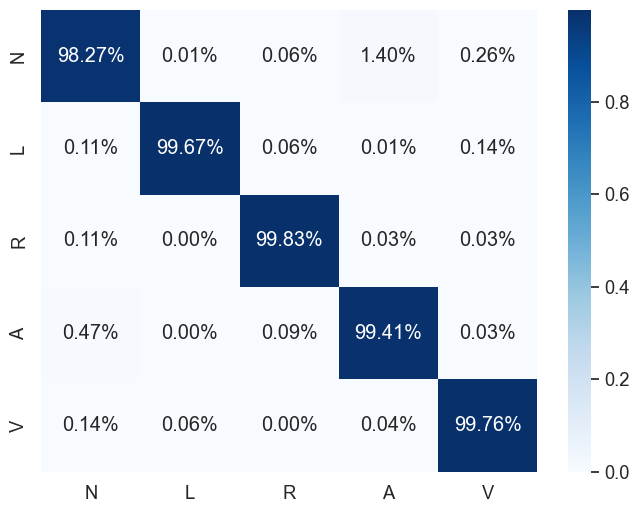

In [123]:
y_pred_gru = gru.predict(train_x)
y_pred_classes_gru = np.argmax(y_pred_gru, axis=1)
y_train_classes_gru = np.argmax(train_y, axis=1)
cm_grutrain = confusion_matrix(y_train_classes_gru, y_pred_classes_gru)
cm_gruptrain = cm_grutrain.astype('float') / cm_grutrain.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm_gruptrain, annot=True, fmt='.2%', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

In [124]:
TP_tgru = cm_grutrain[0][0]
FP_tgru = cm_grutrain[0][1]
FN_tgru = cm_grutrain[1][0]
TN_tgru = cm_grutrain[1][1]

accuracy_tgru = (TP_tgru+TN_tgru) / (TP_tgru+FP_tgru+FN_tgru+TN_tgru)
specificity_tgru = TN_tgru / (TN_tgru + FP_tgru)
sensitivity_tgru = TP_tgru / (TP_tgru + FN_tgru)

print("Specificity:", specificity_tcnn)

Specificity: 1.0


## GRU Test Evaluation

In [125]:
score = gru.evaluate(test_x, test_y) #Evaluation of GRU in test data

print('Test Loss:', score[0])
print('Test accuracy:', score[1])

626/626 [==============================] - 22s 36ms/step - loss: 0.1382 - accuracy: 0.9655
Test Loss: 0.1381961852312088
Test accuracy: 0.965455174446106


In [126]:
y_pred = gru.predict(test_x, batch_size=1000) #GRU model prediction

21/21 [==============================] - 7s 325ms/step


In [127]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

y_true=[]
for element in test_y:
    y_true.append(np.argmax(element))
prediction_proba=gru.predict(test_x)
prediction=np.argmax(prediction_proba,axis=1)

# Calculate the confusion matrix
model_cf_matrix = confusion_matrix(y_true, prediction)

# Calculate specificity for each class
specificity_per_class = []
for i in range(len(classes)):
    tn = np.sum(np.delete(model_cf_matrix, i, axis=0)[:, np.delete(np.arange(len(classes)), i)])
    fp = np.sum(model_cf_matrix[:, i]) - model_cf_matrix[i, i]
    specificity = tn / (tn + fp)
    specificity_per_class.append(specificity)

# Print classification report
print("Classification Report:")
print(classification_report(y_true, prediction, target_names=classes, digits=4))

# Print specificity for each class
for i, class_name in enumerate(classes):
    print(f"Specificity for class {class_name}: {specificity_per_class[i]:.4f}")


626/626 [==============================] - 23s 37ms/step
Classification Report:
              precision    recall  f1-score   support

           N     0.9968    0.9600    0.9781     15003
           L     0.9766    0.9903    0.9834      1644
           R     0.9718    0.9897    0.9807      1460
           A     0.5347    0.9471    0.6835       529
           V     0.9125    0.9766    0.9435      1367

    accuracy                         0.9655     20003
   macro avg     0.8785    0.9727    0.9138     20003
weighted avg     0.9753    0.9655    0.9685     20003

Specificity for class N: 0.9908
Specificity for class L: 0.9979
Specificity for class R: 0.9977
Specificity for class A: 0.9776
Specificity for class V: 0.9931


In [128]:
y_pred_gru = gru.predict(test_x)
y_pred_classes_gru = np.argmax(y_pred_gru, axis=1)
y_test_classes_gru = np.argmax(test_y, axis=1)
cm_gru = confusion_matrix(y_test_classes_gru, y_pred_classes_gru)
print("Confusion Matrix:")
print(cm_gru)

626/626 [==============================] - 22s 35ms/step
Confusion Matrix:
[[14403    34    33   416   117]
 [    6  1628     3     1     6]
 [    7     0  1445     8     0]
 [   20     0     3   501     5]
 [   13     5     3    11  1335]]


<Axes: >

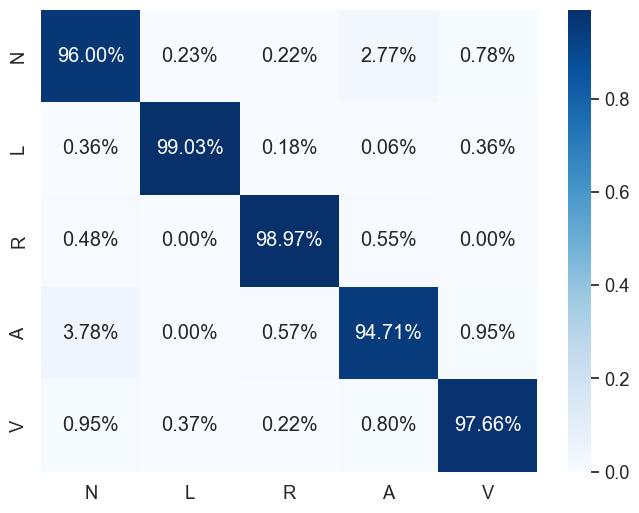

In [131]:
cm_gruptest = cm_gru.astype('float') / cm_gru.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm_gruptest, annot=True, fmt='.2%', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

In [129]:
TP_gru = cm_gru[0][0]
FP_gru = cm_gru[0][1]
FN_gru = cm_gru[1][0]
TN_gru = cm_gru[1][1]

specificity_gru = TN_gru / (TN_gru + FP_gru)

print("Specificity:", specificity_gru)

Specificity: 0.9795427196149218


In [130]:
#RMSE of GRU
score = np.sqrt(metrics.mean_squared_error(y_true,prediction))
print(f"RMSE Score: {score}")

RMSE Score: 0.5633847616341373
